# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [64]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA


# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [65]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep =';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [52]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0        -1                     2          1            2.0   
1        -1                     1          2            5.0   
2        -1                     3          2            3.0   
3         2                     4          2            2.0   
4        -1                     3          1            5.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  3              4                 3               5   
1                  1              5                 2               5   
2                  1              4                 1               2   
3                  4              2                 5               2   
4                  4              3                 4               1   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      5                 3    ...            NaN         NaN   
1                      4                 5    ...            2.0         3.0   
2                      3                 5    ...            3.0         3.0   
3                      1                 2    ...            2.0         2.0   
4                      3                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         NaN         NaN          NaN       NaN       NaN     NaN   
1         2.0         1.0          1.0       5.0       4.0     3.0   
2         1.0         0.0          1.0       4.0       4.0     3.0   
3         2.0         0.0          1.0       3.0       4.0     2.0   
4         2.0         1.0          2.0       3.0       3.0     4.0   

   ORTSGR_KLS9  RELAT_AB  
0          NaN       NaN  
1          5.0       4.0  
2          5.0       2.0  
3          3.0       3.0  
4          6.0       5.0  

[5 rows x 85 columns]

In [53]:
azdias['ALTER_HH']

0          NaN
1          0.0
2         17.0
3         13.0
4         20.0
5         10.0
6          0.0
7         14.0
8         16.0
9         17.0
10        10.0
11         NaN
12        21.0
13        20.0
14         NaN
15        11.0
16        19.0
17         NaN
18         0.0
19         0.0
20         0.0
21         0.0
22         0.0
23        16.0
24         NaN
25        20.0
26         0.0
27        16.0
28        15.0
29        11.0
          ... 
891191    10.0
891192    20.0
891193    13.0
891194    15.0
891195     0.0
891196    17.0
891197    15.0
891198    20.0
891199     0.0
891200    18.0
891201    16.0
891202     0.0
891203     0.0
891204    16.0
891205    10.0
891206    19.0
891207     8.0
891208    15.0
891209     0.0
891210     0.0
891211    14.0
891212    15.0
891213    21.0
891214    17.0
891215     0.0
891216    17.0
891217    16.0
891218    17.0
891219     0.0
891220     0.0
Name: ALTER_HH, Length: 891221, dtype: float64

In [54]:
#Examine the rows and columns in the dataset
azdias.shape

(891221, 85)

In [55]:
#Examine the values in the dataset
azdias.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  891221.000000         891221.000000  891221.000000  886367.000000   
mean       -0.358435              2.777398       1.522098       3.632838   
std         1.198724              1.068775       0.499512       1.595021   
min        -1.000000              1.000000       1.000000       1.000000   
25%        -1.000000              2.000000       1.000000       2.000000   
50%        -1.000000              3.000000       2.000000       4.000000   
75%        -1.000000              4.000000       2.000000       5.000000   
max         3.000000              9.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...          PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...       774706.000000   
mean                2.874167          3.075121      ...            2.253330   
std                 1.486731          1.353248      ...            0.972008   
min                 1.000000          1.000000      ...            0.000000   
25%                 2.000000          2.000000      ...            1.000000   
50%                 3.000000          3.000000      ...            2.000000   
75%                 4.000000          4.000000      ...            3.000000   
max                 5.000000          5.000000      ...            4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  794005.000000  794005.000000   
mean        3.612821       3.381087       3.167854       5.293002   
std         0.973967       1.111598       1.002376       2.303739   
min         1.000000       1.000000       1.000000       0.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       9.000000       9.000000   

           RELAT_AB  
count  794005.00000  
mean        3.07222  
std         1.36298  
min         1.00000  
25%         2.00000  
50%         3.00000  
75%         4.00000  
max         9.00000  

[8 rows x 81 columns]

In [56]:
#Examine the count of values in different columns
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [57]:
# Examine the feat_info dataset
feat_info[feat_info['missing_or_unknown']=='[0]']

attribute information_level         type missing_or_unknown
3         CJT_GESAMTTYP            person  categorical                [0]
11          GEBURTSJAHR            person      numeric                [0]
15  LP_LEBENSPHASE_FEIN            person        mixed                [0]
16  LP_LEBENSPHASE_GROB            person        mixed                [0]
17      LP_FAMILIE_FEIN            person  categorical                [0]
18      LP_FAMILIE_GROB            person  categorical                [0]
19       LP_STATUS_FEIN            person  categorical                [0]
20       LP_STATUS_GROB            person  categorical                [0]
23       RETOURTYP_BK_S            person      ordinal                [0]
43             ALTER_HH         household     interval                [0]
50  ANZ_HAUSHALTE_AKTIV          building      numeric                [0]
54     MIN_GEBAEUDEJAHR          building      numeric                [0]

In [58]:
#Examine the count of values in each column of feat_info dataset
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [59]:
#Create copies of the orginal dataset
feat_info_copy = feat_info.copy()
azdias_copy = azdias.copy()

In [60]:
#reset index in th original dataset
azdias.reset_index()

index  AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            0        -1                     2          1            2.0   
1            1        -1                     1          2            5.0   
2            2        -1                     3          2            3.0   
3            3         2                     4          2            2.0   
4            4        -1                     3          1            5.0   
5            5         3                     1          2            2.0   
6            6        -1                     2          2            5.0   
7            7        -1                     1          1            3.0   
8            8        -1                     3          1            3.0   
9            9        -1                     3          2            4.0   
10          10         0                     3          2            1.0   
11          11        -1                     2          1            6.0   
12          12        -1                     3          1            6.0   
13          13        -1                     1          2            5.0   
14          14        -1                     3          1            6.0   
15          15         1                     4          2            4.0   
16          16        -1                     1          2            1.0   
17          17        -1                     2          1            6.0   
18          18        -1                     2          2            6.0   
19          19        -1                     3          1            3.0   
20          20        -1                     2          2            4.0   
21          21        -1                     2          1            3.0   
22          22        -1                     1          1            4.0   
23          23        -1                     3          1            3.0   
24          24        -1                     3          2            6.0   
25          25        -1                     1          1            3.0   
26          26        -1                     3          1            3.0   
27          27        -1                     3          1            4.0   
28          28        -1                     3          1            2.0   
29          29         2                     4          2            1.0   
...        ...       ...                   ...        ...            ...   
891191  891191         1                     4          2            1.0   
891192  891192        -1                     1          2            3.0   
891193  891193         2                     4          1            3.0   
891194  891194        -1                     3          1            4.0   
891195  891195         2                     4          2            6.0   
891196  891196        -1                     2          2            6.0   
891197  891197        -1                     3          2            1.0   
891198  891198        -1                     3          1            5.0   
891199  891199        -1                     2          1            3.0   
891200  891200        -1                     1          2            3.0   
891201  891201        -1                     3          1            3.0   
891202  891202        -1                     2          2            5.0   
891203  891203        -1                     4          2            1.0   
891204  891204        -1                     3          1            5.0   
891205  891205         1                     4          1            2.0   
891206  891206        -1                     1          2            4.0   
891207  891207         1                     3          2            1.0   
891208  891208        -1                     4          1            2.0   
891209  891209        -1                     1          2            5.0   
891210  891210        -1                     3          1            5.0   
891211  891211        -1                     3          1

In [61]:
# Identify missing or unknown data values and convert them to NaN
#feat_info.set_index('attribute', inplace=True)
def convert_missing_to_NaN(df):
    for i,x in enumerate(df.iteritems()):
        missing_values = feat_info['missing_or_unknown'][i]
        name = x[0]
        missing_unknown = missing_values[1:-1].split(',')
        if missing_unknown != ['']:
            replace_data=[]
            for x in missing_unknown:
                if x in ['XX','X']:
                    replace_data.append(x)
                else:
                    replace_data.append(int(x))
            df[name] = df[name].replace(replace_data,np.nan)
            #for x in df[name]:
                #if x > -5:
                    #x.astype(int)
                    #x=int(x)
            #df[name] = df[name].replace(x, np.nan)
    return df

In [62]:
azdias = convert_missing_to_NaN(azdias)

In [63]:
#Since the above process takes a long time..we look to save the file to a csv
azdias.to_csv('azdias_parsed.csv', sep=';', index = False)

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [66]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.

#Loading the dataset from the parsed csv file
azdias_parsed = pd.read_csv('azdias_parsed.csv', sep =';')

azdias_parsed = pd.DataFrame(azdias_parsed)

In [67]:
prop=[]
for col in ['ALTER_HH','GEBURTSJAHR','KBA05_BAUMAX','KK_KUNDENTYP','AGER_TYP','TITEL_KZ']:
    prop.append((azdias.shape[0]-azdias[col].count())/azdias.shape[0])

In [68]:
prop

[0.082470004634091876,
 0.0,
 0.14959701353536328,
 0.65596748730112953,
 0.0,
 0.082470004634091876]

In [69]:
for x in azdias['ALTER_HH']:
    if x == 0:
        print(x)
    

0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0
0.0


In [70]:
#Examing the new dataset
azdias_parsed.describe()

AGER_TYP  ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  \
count  205378.000000         888340.000000  891221.000000  886367.000000   
mean        1.743410              2.757217       1.522098       3.632838   
std         0.674312              1.009951       0.499512       1.595021   
min         1.000000              1.000000       1.000000       1.000000   
25%         1.000000              2.000000       1.000000       2.000000   
50%         2.000000              3.000000       2.000000       4.000000   
75%         2.000000              4.000000       2.000000       5.000000   
max         3.000000              4.000000       2.000000       6.000000   

       FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
count      891221.000000  891221.000000     891221.000000   891221.000000   
mean            3.074528       2.821039          3.401106        3.033328   
std             1.321055       1.464749          1.322134        1.529603   
min             1.000000       1.000000          1.000000        1.000000   
25%             2.000000       1.000000          3.000000        2.000000   
50%             3.000000       3.000000          3.000000        3.000000   
75%             4.000000       4.000000          5.000000        5.000000   
max             5.000000       5.000000          5.000000        5.000000   

       FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER      ...           PLZ8_ANTG1  \
count          891221.000000     891221.000000      ...        774706.000000   
mean                2.874167          3.075121      ...             2.253330   
std                 1.486731          1.353248      ...             0.972008   
min                 1.000000          1.000000      ...             0.000000   
25%                 2.000000          2.000000      ...             1.000000   
50%                 3.000000          3.000000      ...             2.000000   
75%                 4.000000          4.000000      ...             3.000000   
max                 5.000000          5.000000      ...             4.000000   

          PLZ8_ANTG2     PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        2.801858       1.595426       0.699166       1.943913   
std         0.920309       0.986736       0.727137       1.459654   
min         0.000000       0.000000       0.000000       1.000000   
25%         2.000000       1.000000       0.000000       1.000000   
50%         3.000000       2.000000       1.000000       1.000000   
75%         3.000000       2.000000       1.000000       3.000000   
max         4.000000       3.000000       2.000000       5.000000   

            PLZ8_HHZ       PLZ8_GBZ         ARBEIT    ORTSGR_KLS9  \
count  774706.000000  774706.000000  793846.000000  793947.000000   
mean        3.612821       3.381087       3.166686       5.293389   
std         0.973967       1.111598       0.999072       2.303379   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       3.000000       4.000000   
50%         4.000000       3.000000       3.000000       5.000000   
75%         4.000000       4.000000       4.000000       7.000000   
max         5.000000       5.000000       5.000000       9.000000   

            RELAT_AB  
count  793846.000000  
mean        3.071033  
std         1.360532  
min         1.000000  
25%         2.000000  
50%         3.000000  
75%         4.000000  
max         5.000000  

[8 rows x 83 columns]

In [71]:
#Testing the formula to identify NaN values
azdias_parsed.shape[0] - azdias_parsed['AGER_TYP'].count()

685843

In [72]:
# Investigate patterns in the amount of missing data in each column.
zx=[]
for columns in azdias_parsed.columns:
    zx.append(azdias_parsed.shape[0]- azdias_parsed[columns].count()) 

In [73]:
#creating a dataframe
zx = pd.DataFrame(zx)

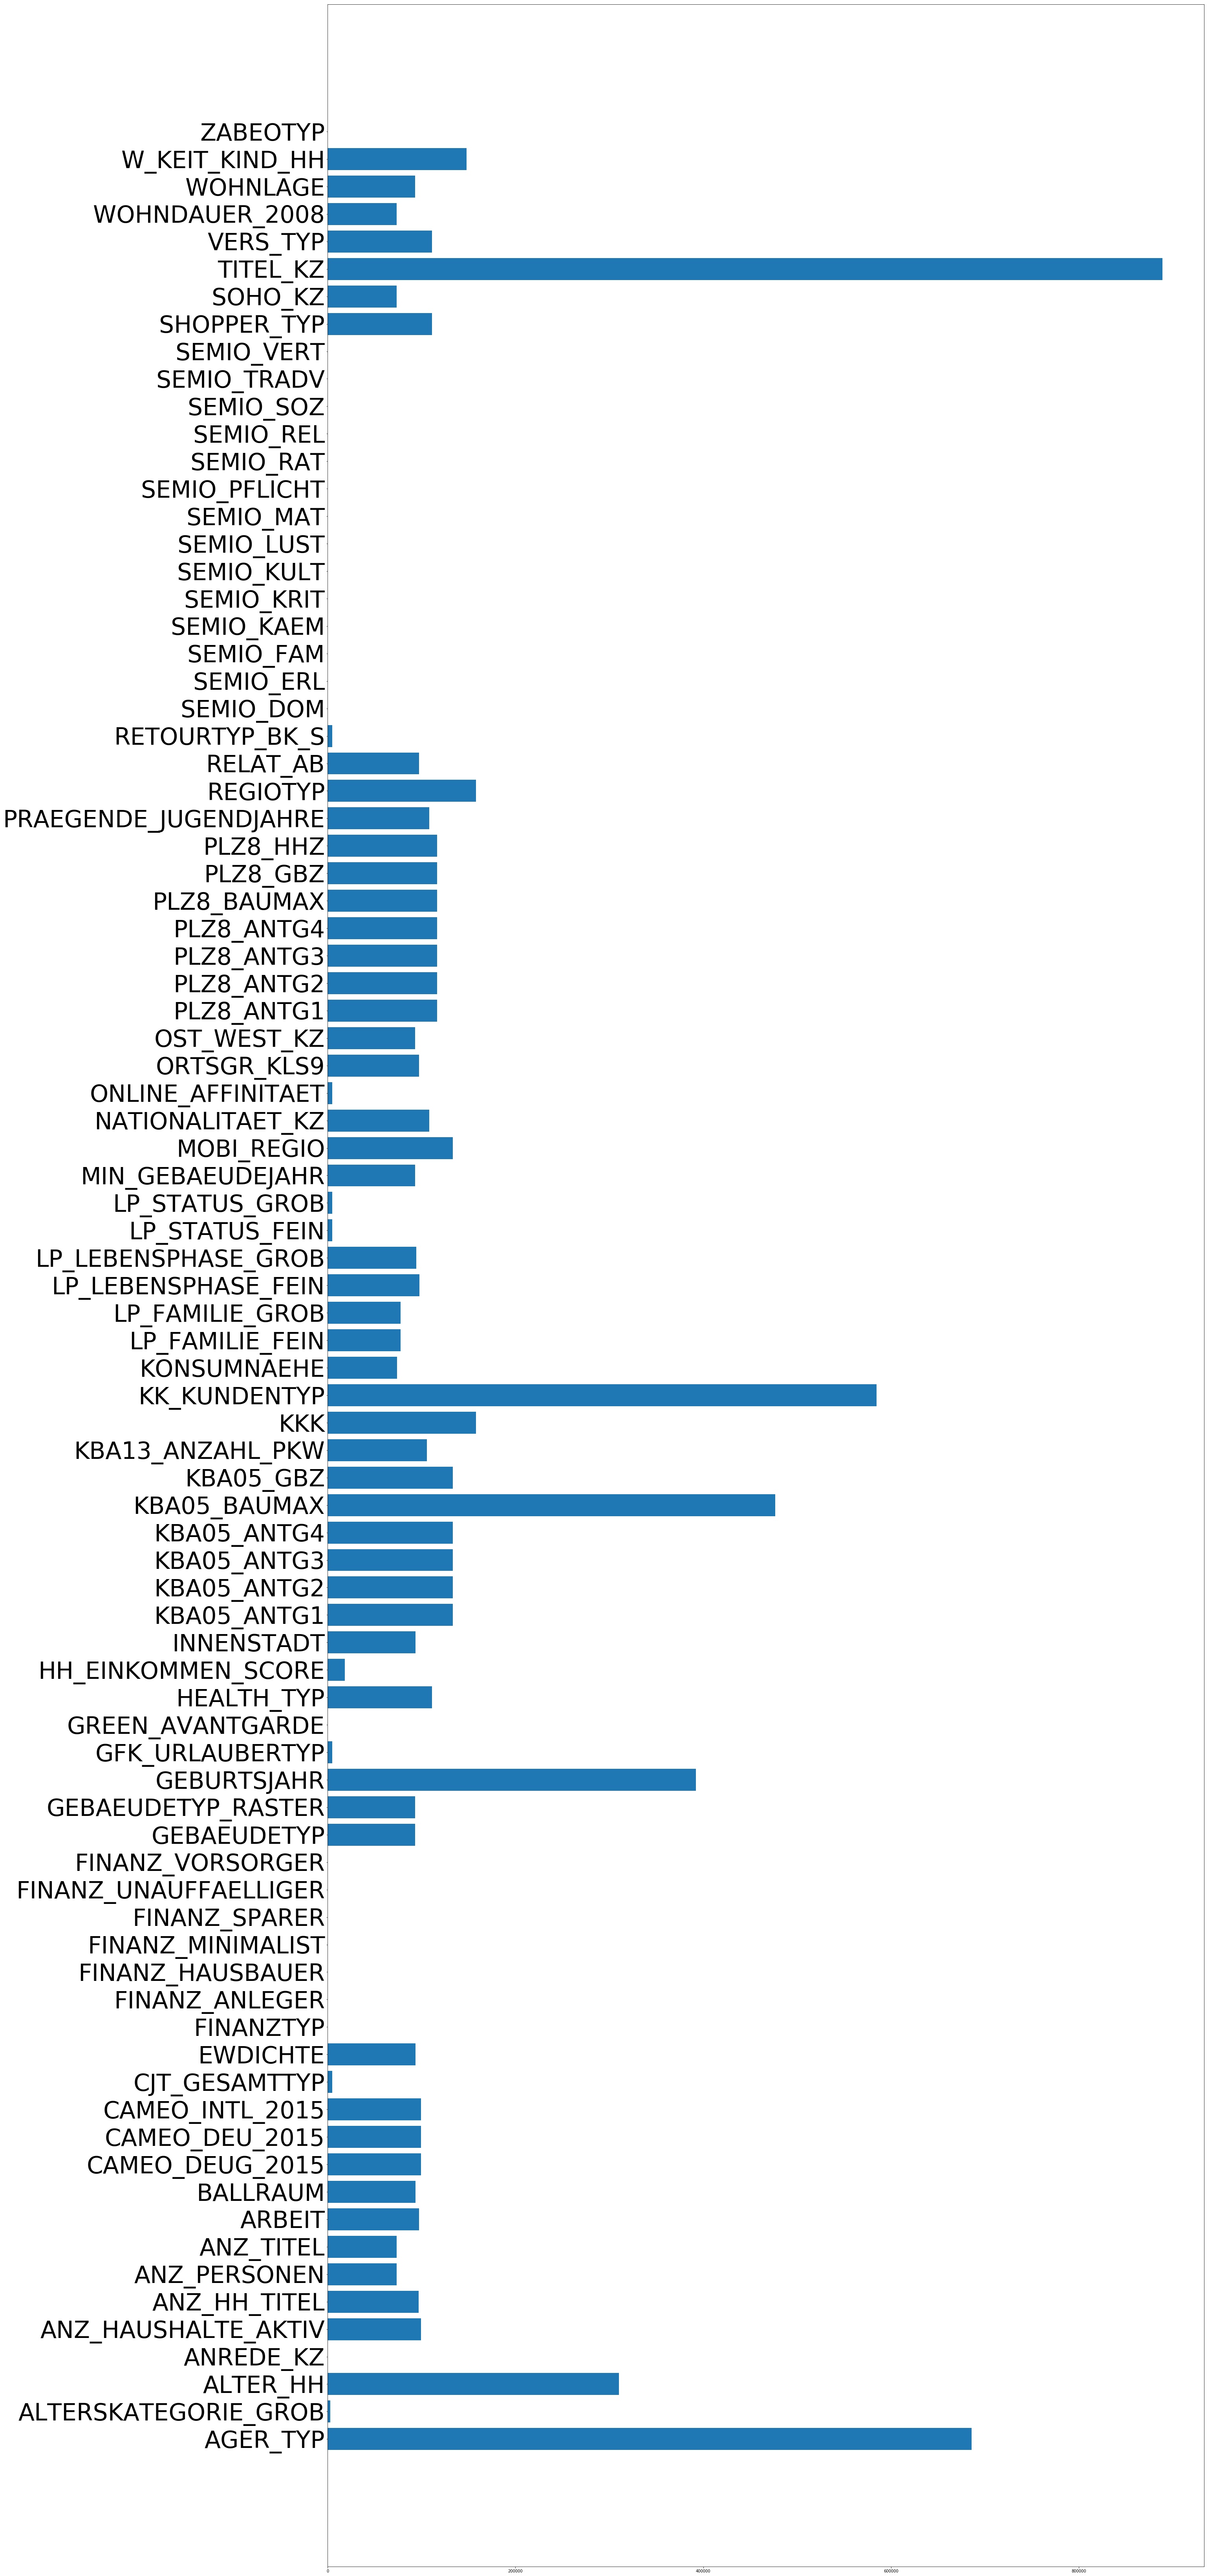

In [74]:
#Identifying the columns with highest NaN values
plt.figure(figsize=(40,120))
plt.barh(azdias_parsed.columns, zx[0], align='center')
plt.rc('ytick', labelsize=60)

In [75]:
#Narrowing down columns with more than 12% of NaN values
high_NaN =[]
for column in azdias_parsed.columns:
    if ((azdias_parsed.shape[0]- azdias_parsed[column].count())/ azdias_parsed.shape[0]) > 0.20:
        high_NaN.append(column)

high_NaN
    

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [76]:
# Dropping columns that have 12% of their values to be NaN 
azdias_parsed.drop(high_NaN, axis=1,inplace = True)

In [77]:
#Examining the shape of the new dataset
azdias_parsed.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns with NaN values to be greater than 20% of the total count were removed from the dataframe I felt this was a suitable as removing too many columns may cause a hinderance to our analysis. Some of the columns removed  from our dataframe are  based on "Best ager typology", "year of birth", "Academic title flag", "Birth date of head of household", "consumer pattern over twelve months" and "Most common building type within microcell". We see that age typology, year of birth and birth date of head of household are related to eachother and NaN values could be for the same individual. We find that most columns that focus on the personality typology (SEMIO_) and financial typology(FINANZ_) do not have any missing values. This could be because determining a value under one personality typology column could  help in identifying values for other columns. The above method could also be used for the financial typology column. This could be reason for zero NaN values in the two columns.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [78]:
# How much data is missing in each row of the dataset?
dx=azdias_parsed
column_sum = azdias_parsed.columns
dx['NaN_count'] = (azdias_parsed.shape[1]-(azdias_parsed[column_sum].count(axis=1))) 


In [79]:
#Examing the missing data count in NaN_count column
dx.describe()

ALTERSKATEGORIE_GROB      ANREDE_KZ  CJT_GESAMTTYP  FINANZ_MINIMALIST  \
count         888340.000000  891221.000000  886367.000000      891221.000000   
mean               2.757217       1.522098       3.632838           3.074528   
std                1.009951       0.499512       1.595021           1.321055   
min                1.000000       1.000000       1.000000           1.000000   
25%                2.000000       1.000000       2.000000           2.000000   
50%                3.000000       2.000000       4.000000           3.000000   
75%                4.000000       2.000000       5.000000           4.000000   
max                4.000000       2.000000       6.000000           5.000000   

       FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
count  891221.000000     891221.000000   891221.000000          891221.000000   
mean        2.821039          3.401106        3.033328               2.874167   
std         1.464749          1.322134        1.529603               1.486731   
min         1.000000          1.000000        1.000000               1.000000   
25%         1.000000          3.000000        2.000000               2.000000   
50%         3.000000          3.000000        3.000000               3.000000   
75%         4.000000          5.000000        5.000000               4.000000   
max         5.000000          5.000000        5.000000               5.000000   

       FINANZ_HAUSBAUER      FINANZTYP      ...           PLZ8_ANTG2  \
count     891221.000000  891221.000000      ...        774706.000000   
mean           3.075121       3.790586      ...             2.801858   
std            1.353248       1.987876      ...             0.920309   
min            1.000000       1.000000      ...             0.000000   
25%            2.000000       2.000000      ...             2.000000   
50%            3.000000       4.000000      ...             3.000000   
75%            4.000000       6.000000      ...             3.000000   
max            5.000000       6.000000      ...             4.000000   

          PLZ8_ANTG3     PLZ8_ANTG4    PLZ8_BAUMAX       PLZ8_HHZ  \
count  774706.000000  774706.000000  774706.000000  774706.000000   
mean        1.595426       0.699166       1.943913       3.612821   
std         0.986736       0.727137       1.459654       0.973967   
min         0.000000       0.000000       1.000000       1.000000   
25%         1.000000       0.000000       1.000000       3.000000   
50%         2.000000       1.000000       1.000000       4.000000   
75%         2.000000       1.000000       3.000000       4.000000   
max         3.000000       2.000000       5.000000       5.000000   

            PLZ8_GBZ         ARBEIT    ORTSGR_KLS9       RELAT_AB  \
count  774706.000000  793846.000000  793947.000000  793846.000000   
mean        3.381087       3.166686       5.293389       3.071033   
std         1.111598       0.999072       2.303379       1.360532   
min         1.000000       1.000000       1.000000       1.000000   
25%         3.000000       3.000000       4.000000       2.000000   
50%         3.000000       3.000000       5.000000       3.000000   
75%         4.000000       4.000000       7.000000       4.000000   
max         5.000000       5.000000       9.000000       5.000000   

           NaN_count  
count  891221.000000  
mean        5.649894  
std        13.234687  
min         0.000000  
25%         0.000000  
50%         0.000000  
75%         3.000000  
max        49.000000  

[8 rows x 78 columns]

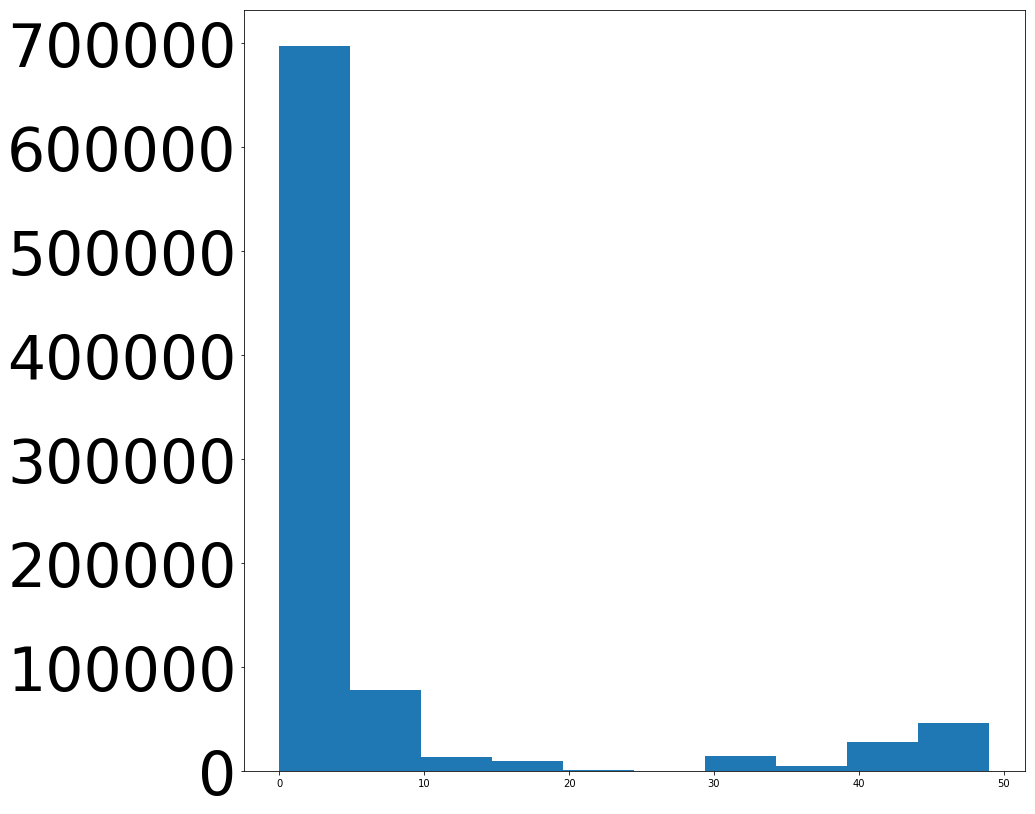

In [80]:
#Looking at how the NaN values are distributed
fig = plt.figure(figsize=(14, 14))
plt.hist(dx['NaN_count'])
plt.rcParams['ytick.labelsize']=6
plt.show()


In [81]:
# Write code to divide the data into two subsets based on the number of missing values in each row.
subset1 = dx[dx['NaN_count'] < 12]
subset2 = dx[dx['NaN_count'] > 12]


In [82]:
# Creating a dataframe for the subsets
subset1 = pd.DataFrame(subset1)
subset2 = pd.DataFrame(subset2)

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


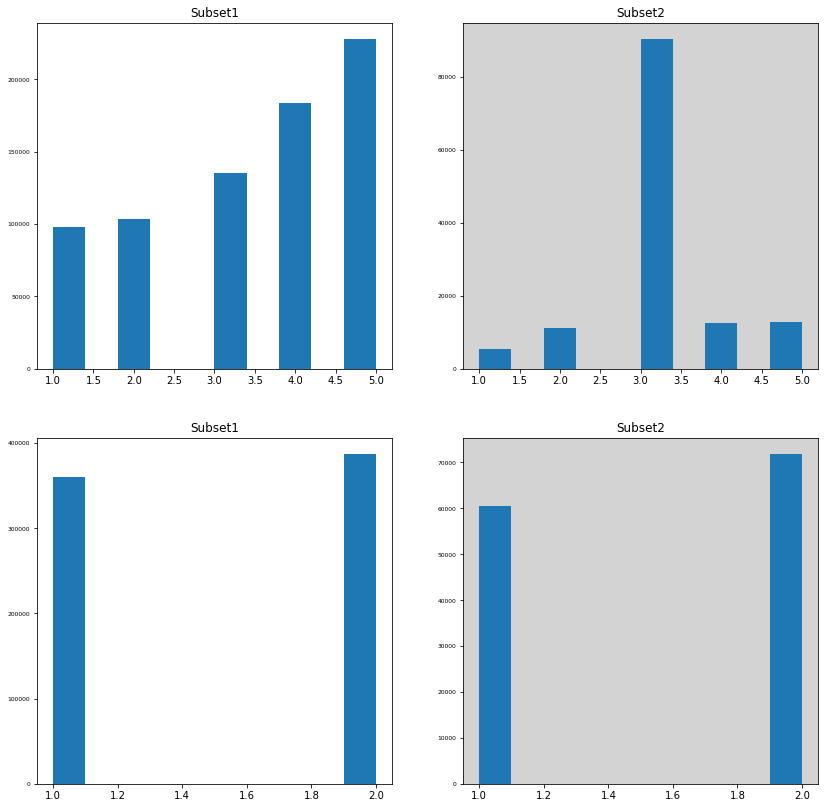

In [83]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['FINANZ_VORSORGER'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['FINANZ_VORSORGER'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['ANREDE_KZ'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['ANREDE_KZ'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()

/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


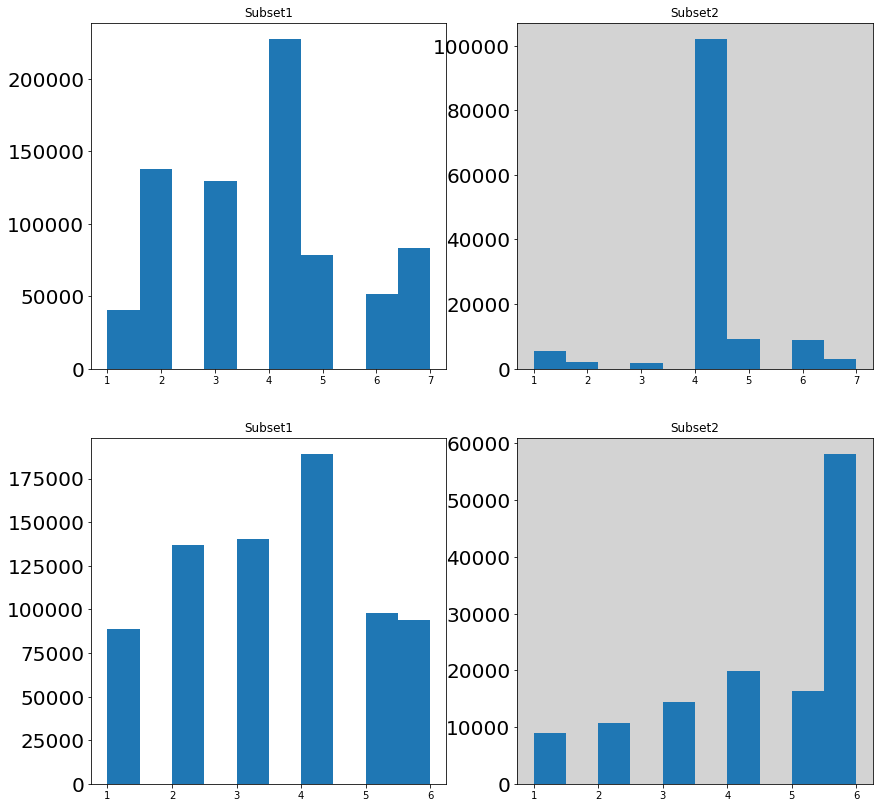

In [84]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['SEMIO_RAT'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['SEMIO_RAT'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['CJT_GESAMTTYP'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['CJT_GESAMTTYP'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()



/opt/conda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


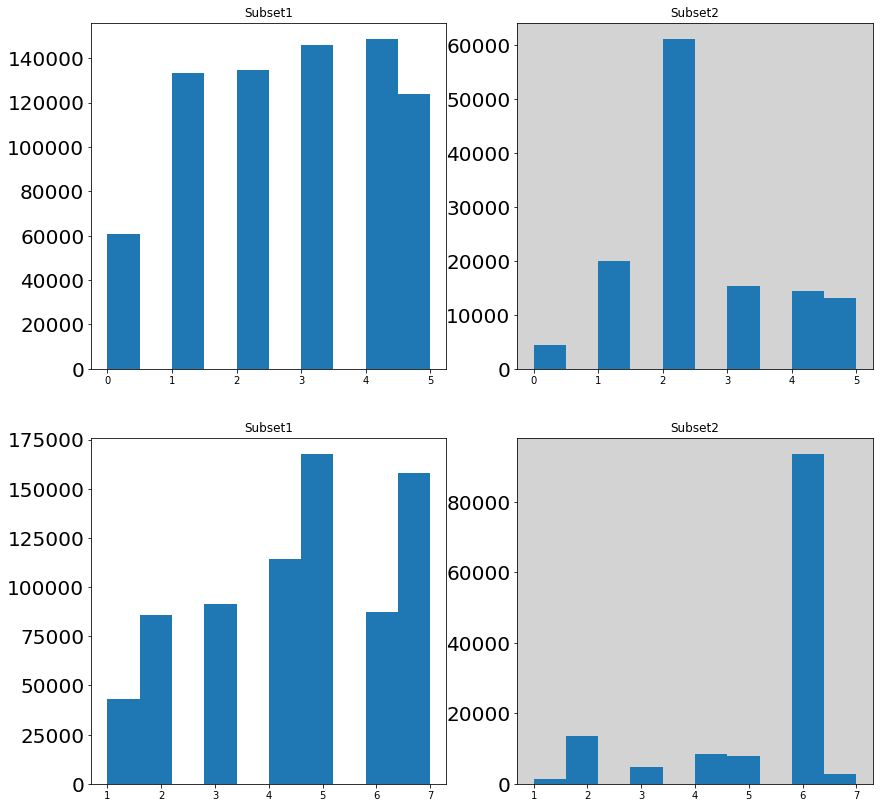

In [85]:
#Examing columns based on values in subset1 and subset2
python_course_green = "#476042"
fig = plt.figure(figsize=(14, 14))
sub1 = fig.add_subplot(221) 
sub1.set_title('Subset1') 
sub1.hist(subset1['ONLINE_AFFINITAET'].dropna())
sub2 = fig.add_subplot(222, axisbg="lightgrey")
sub2.set_title('Subset2')
sub2.hist(subset2['ONLINE_AFFINITAET'].dropna())
sub3 = fig.add_subplot(223)
sub3.set_title('Subset1')
sub3.hist(subset1['SEMIO_DOM'].dropna())
sub4 = fig.add_subplot(224, axisbg="lightgrey")
sub4.set_title('Subset2')
sub4.hist(subset2['SEMIO_DOM'].dropna())
plt.rcParams['ytick.labelsize']=20
plt.show()

#### Discussion 1.1.3: Assess Missing Data in Each Row

The rows in subset1 are well distributed when compared to rows in subset2. On observing in the graph with "CJT_GESAMTTYP" (Customer-Journey Typology preferred information and buying channels for customer) and "ONLINE_AFFINITAET" (Online affinity), we find fewer but same range of values in both subsets. We find the same pattern other distributions with zero NaN values.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [33]:
# How many features are there of each data type?
cat = feat_info[feat_info['type'] == 'categorical']
mix = feat_info[feat_info['type'] == 'mixed']


In [34]:
# reseting the index in the dataframe
cat = cat.reset_index()
mix = mix.reset_index()

In [35]:
# Examing the dataset
cat.head()

index        attribute information_level         type missing_or_unknown
0      0         AGER_TYP            person  categorical             [-1,0]
1      2        ANREDE_KZ            person  categorical             [-1,0]
2      3    CJT_GESAMTTYP            person  categorical                [0]
3     10        FINANZTYP            person  categorical               [-1]
4     12  GFK_URLAUBERTYP            person  categorical                 []

In [36]:
#Reseting the subset1 dataset
subset1.reset_index()

index  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0            1                   1.0          2            5.0   
1            2                   3.0          2            3.0   
2            3                   4.0          2            2.0   
3            4                   3.0          1            5.0   
4            5                   1.0          2            2.0   
5            6                   2.0          2            5.0   
6            7                   1.0          1            3.0   
7            8                   3.0          1            3.0   
8            9                   3.0          2            4.0   
9           10                   3.0          2            1.0   
10          12                   3.0          1            6.0   
11          13                   1.0          2            5.0   
12          15                   4.0          2            4.0   
13          16                   1.0          2            1.0   
14          18                   2.0          2            6.0   
15          19                   3.0          1            3.0   
16          20                   2.0          2            4.0   
17          21                   2.0          1            3.0   
18          22                   1.0          1            4.0   
19          23                   3.0          1            3.0   
20          25                   1.0          1            3.0   
21          27                   3.0          1            4.0   
22          28                   3.0          1            2.0   
23          29                   4.0          2            1.0   
24          31                   2.0          2            6.0   
25          32                   1.0          1            4.0   
26          33                   2.0          2            4.0   
27          34                   1.0          2            2.0   
28          36                   3.0          2            2.0   
29          37                   4.0          1            2.0   
...        ...                   ...        ...            ...   
781250  891190                   3.0          1            1.0   
781251  891191                   4.0          2            1.0   
781252  891192                   1.0          2            3.0   
781253  891193                   4.0          1            3.0   
781254  891194                   3.0          1            4.0   
781255  891195                   4.0          2            6.0   
781256  891196                   2.0          2            6.0   
781257  891197                   3.0          2            1.0   
781258  891198                   3.0          1            5.0   
781259  891199                   2.0          1            3.0   
781260  891200                   1.0          2            3.0   
781261  891201                   3.0          1            3.0   
781262  891202                   2.0          2            5.0   
781263  891204                   3.0          1            5.0   
781264  891205                   4.0          1            2.0   
781265  891206                   1.0          2            4.0   
781266  891207                   3.0          2            1.0   
781267  891208                   4.0          1            2.0   
781268  891209                   1.0          2            5.0   
781269  891210                   3.0          1            5.0   
781270  891211                   3.0          1            2.0   
781271  891212                   4.0          1            1.0   
781272  891213                   4.0          2            5.0   
781273  891214                   1.0          2            4.0   
781274  891215                   2.0          2            6.0   
781275  891216                   3.0          2            5.0   
781276  891217                   2.0          1            4.0   
781277  891218                   2.0          2            4.0   
781278  891219                   1.0          1  

In [37]:
# Identfying and creating a dataet with category data type values
category=[]
category = pd.DataFrame(category)
for columns in subset1.columns:
    for col in cat['attribute']:
        if columns == col:
            category[col] = (subset1[col])

In [38]:
# Creating a dataframe
category = pd.DataFrame(category)
category.head()

ANREDE_KZ  CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  \
1          2            5.0          1             10.0                 0   
2          2            3.0          1             10.0                 1   
3          2            2.0          6              1.0                 0   
4          1            5.0          5              5.0                 0   
5          2            2.0          2              1.0                 0   

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
1              5.0              3.0             2.0             1.0   
2              1.0              1.0             3.0             2.0   
3              NaN              NaN             9.0             4.0   
4             10.0              5.0             3.0             2.0   
5              1.0              1.0             4.0             2.0   

   NATIONALITAET_KZ  SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP  \
1               1.0          3.0      1.0       2.0         5          8.0   
2               1.0          2.0      0.0       1.0         5          1.0   
3               1.0          1.0      0.0       1.0         3          1.0   
4               1.0          2.0      0.0       2.0         4          1.0   
5               1.0          0.0      0.0       2.0         4          1.0   

  OST_WEST_KZ  CAMEO_DEUG_2015 CAMEO_DEU_2015  
1           W              8.0             8A  
2           W              4.0             4C  
3           W              2.0             2A  
4           W              6.0             6B  
5           W              8.0             8C

In [39]:
# Looking at the values in category column
for column in category.columns:
    print(category[column].value_counts())
    

2    407251
1    374029
Name: ANREDE_KZ, dtype: int64
4.0    193740
3.0    143795
2.0    139828
5.0    109463
6.0     99083
1.0     91492
Name: CJT_GESAMTTYP, dtype: int64
6    287209
1    192917
5    104718
2    102490
4     55135
3     38811
Name: FINANZTYP, dtype: int64
12.0    125750
10.0    101411
8.0      81903
11.0     73959
5.0      69938
4.0      60181
9.0      55754
3.0      52946
1.0      50174
7.0      40090
2.0      39748
6.0      25547
Name: GFK_URLAUBERTYP, dtype: int64
0    609397
1    171883
Name: GREEN_AVANTGARDE, dtype: int64
1.0     395611
10.0    127279
2.0      96213
11.0     48237
8.0      21336
7.0      18705
4.0      11255
5.0      10978
9.0      10291
6.0       7767
3.0       4399
Name: LP_FAMILIE_FEIN, dtype: int64
1.0    395611
5.0    185807
2.0     96213
4.0     47808
3.0     26632
Name: LP_FAMILIE_GROB, dtype: int64
1.0     204891
9.0     131409
2.0     110084
10.0    109424
4.0      73364
3.0      68452
6.0      28257
5.0      26393
8.0      16081
7.0    

In [40]:
# looking at the values in the OST_WEST_KZ column
category['OST_WEST_KZ'].value_counts()

W    615657
O    165623
Name: OST_WEST_KZ, dtype: int64

In [41]:
# Looking at the values in the CAMEO_DEU_2015 column
category['CAMEO_DEU_2015'].value_counts()

6B    55888
8A    52124
4C    46659
2D    34407
3C    34175
7A    33917
3D    33668
8B    33068
4A    32270
8C    30783
9D    28414
9B    27512
9C    24863
7B    24178
9A    20407
2C    18869
8D    17461
6E    15961
2B    15044
5D    14708
6C    14599
2A    12912
1D    11766
5A    11183
1A    10640
5B    10170
5C     9642
7C     8974
4B     8814
3A     8785
4D     8442
3B     6718
6A     6697
9E     6173
6D     6003
6F     5294
7D     5268
4E     5224
1E     4978
7E     4541
5F     4221
1C     4215
1B     3998
5E     3540
Name: CAMEO_DEU_2015, dtype: int64

In [42]:
## Identfying and creating a dataet with mixed data type values
mixed=[]
mixed = pd.DataFrame(mixed)
for columns in subset1.columns:
    for col in mix['attribute']:
        if columns == col:
            mixed[col] = (subset1[col])

In [43]:
# Creating a dataframe
mixed = pd.DataFrame(mixed)
mixed.head()

LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  WOHNLAGE  \
1                 21.0                  6.0                   14.0       4.0   
2                  3.0                  1.0                   15.0       2.0   
3                  NaN                  NaN                    8.0       7.0   
4                 32.0                 10.0                    8.0       3.0   
5                  8.0                  2.0                    3.0       7.0   

   CAMEO_INTL_2015  PLZ8_BAUMAX  
1             51.0          1.0  
2             24.0          1.0  
3             12.0          1.0  
4             43.0          2.0  
5             54.0          1.0

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [44]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
subset1['OST_WEST_KZ'] =subset1['OST_WEST_KZ'].astype('category') 
subset1['OST_WEST_KZ'] = subset1['OST_WEST_KZ'].cat.codes


In [45]:
# Dropping the multi-level categorical column in the subset1 dataset
subset1.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [46]:
# Dropping the multi-level categorical column in category dataset
category.drop('CAMEO_DEU_2015', axis=1, inplace=True)

In [47]:
# Adjusting the index in the category dataset
category.index = pd.RangeIndex(len(category.index))


In [48]:
# Examining the category dataset
category.head()

ANREDE_KZ  CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  GREEN_AVANTGARDE  \
0          2            5.0          1             10.0                 0   
1          2            3.0          1             10.0                 1   
2          2            2.0          6              1.0                 0   
3          1            5.0          5              5.0                 0   
4          2            2.0          2              1.0                 0   

   LP_FAMILIE_FEIN  LP_FAMILIE_GROB  LP_STATUS_FEIN  LP_STATUS_GROB  \
0              5.0              3.0             2.0             1.0   
1              1.0              1.0             3.0             2.0   
2              NaN              NaN             9.0             4.0   
3             10.0              5.0             3.0             2.0   
4              1.0              1.0             4.0             2.0   

   NATIONALITAET_KZ  SHOPPER_TYP  SOHO_KZ  VERS_TYP  ZABEOTYP  GEBAEUDETYP  \
0               1.0          3.0      1.0       2.0         5          8.0   
1               1.0          2.0      0.0       1.0         5          1.0   
2               1.0          1.0      0.0       1.0         3          1.0   
3               1.0          2.0      0.0       2.0         4          1.0   
4               1.0          0.0      0.0       2.0         4          1.0   

  OST_WEST_KZ  CAMEO_DEUG_2015  
0           W              8.0  
1           W              4.0  
2           W              2.0  
3           W              6.0  
4           W              8.0

In [49]:
# Reset the index in category dataset
category.reset_index(drop=True)

ANREDE_KZ  CJT_GESAMTTYP  FINANZTYP  GFK_URLAUBERTYP  \
0               2            5.0          1             10.0   
1               2            3.0          1             10.0   
2               2            2.0          6              1.0   
3               1            5.0          5              5.0   
4               2            2.0          2              1.0   
5               2            5.0          4             12.0   
6               1            3.0          5              9.0   
7               1            3.0          6              3.0   
8               2            4.0          1             12.0   
9               2            1.0          6              8.0   
10              1            6.0          3             10.0   
11              2            5.0          1             12.0   
12              2            4.0          2             12.0   
13              2            1.0          3             10.0   
14              2            6.0          1             11.0   
15              1            3.0          5              8.0   
16              2            4.0          3             11.0   
17              1            3.0          3             11.0   
18              1            4.0          1              4.0   
19              1            3.0          6             12.0   
20              1            3.0          4              1.0   
21              1            4.0          5              8.0   
22              1            2.0          3              1.0   
23              2            1.0          6              5.0   
24              2            6.0          1              1.0   
25              1            4.0          3             10.0   
26              2            4.0          5              5.0   
27              2            2.0          2              5.0   
28              2            2.0          6              5.0   
29              1            2.0          6              5.0   
...           ...            ...        ...              ...   
781250          1            1.0          2              3.0   
781251          2            1.0          2              6.0   
781252          2            3.0          1             10.0   
781253          1            3.0          5              4.0   
781254          1            4.0          3              9.0   
781255          2            6.0          2              5.0   
781256          2            6.0          1             12.0   
781257          2            1.0          5              5.0   
781258          1            5.0          1             10.0   
781259          1            3.0          1             11.0   
781260          2            3.0          1             12.0   
781261          1            3.0          6              7.0   
781262          2            5.0          1             10.0   
781263          1            5.0          6             11.0   
781264          1            2.0          2              5.0   
781265          2            4.0          4             12.0   
781266          2            1.0          2              8.0   
781267          1            2.0          6             10.0   
781268          2            5.0          1              9.0   
781269          1            5.0          6              4.0   
781270          1            2.0          2              1.0   
781271          1            1.0          5              4.0   
781272          2            5.0          6              8.0   
781273          2            4.0          1             10.0   
781274          2            6.0          1             12.0   
781275          2            5.0          1             12.0   
781276          1            4.0          6              1.0   
781277          2            4.0          1             10.0   
781278          1            3.0          1              9.0   
781279          1            1.0          6             12.0   

        GREEN_AVANTGARDE  LP_FAMILIE_FE

In [50]:
# Examining the feat_info dataset
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

In [51]:
# Making the col_names to be the index
feat_info['col_names'] = feat_info.index

In [52]:
# Making the attribute column to be the index
feat_info.set_index('attribute', inplace=True)

In [53]:
# Identifying category columns with more than 2 unqiue values
non_binary_cat = []
for col in category.columns:
    if feat_info.loc[col].type == 'categorical' and len(subset1[col].unique()) > 2:
        non_binary_cat.append(col)
            

In [54]:
# Examining these values
non_binary_cat

['CJT_GESAMTTYP',
 'FINANZTYP',
 'GFK_URLAUBERTYP',
 'LP_FAMILIE_FEIN',
 'LP_FAMILIE_GROB',
 'LP_STATUS_FEIN',
 'LP_STATUS_GROB',
 'NATIONALITAET_KZ',
 'SHOPPER_TYP',
 'VERS_TYP',
 'ZABEOTYP',
 'GEBAEUDETYP',
 'CAMEO_DEUG_2015']

In [55]:
# Dropping these values from the subset1 dataset
subset1.drop(non_binary_cat, axis=1, inplace=True)

In [56]:
# Looking at the shape for subset1
subset1.shape

(781280, 66)

#### Discussion 1.2.1: Re-Encode Categorical Features

We find that column 'OST_WEST_KZ has two categorical values. We can use label encoding to encode the variables as numbers to the column. We find that the column 'CAMEO_DEU_2015' has multiple categorical values, we can choose to drop this column. As one hot encoding this column, will create too many columns for our analysis. We also drop all other categorical columns to help with our analysis.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [57]:
# Examining the mixed dataset
mixed.head()


LP_LEBENSPHASE_FEIN  LP_LEBENSPHASE_GROB  PRAEGENDE_JUGENDJAHRE  WOHNLAGE  \
1                 21.0                  6.0                   14.0       4.0   
2                  3.0                  1.0                   15.0       2.0   
3                  NaN                  NaN                    8.0       7.0   
4                 32.0                 10.0                    8.0       3.0   
5                  8.0                  2.0                    3.0       7.0   

   CAMEO_INTL_2015  PLZ8_BAUMAX  
1             51.0          1.0  
2             24.0          1.0  
3             12.0          1.0  
4             43.0          2.0  
5             54.0          1.0

In [58]:
# Examining the values in the PRAEGENDE_JUGENDJAHRE
subset1['PRAEGENDE_JUGENDJAHRE'].value_counts()

14.0    178630
8.0     138927
10.0     83996
5.0      83729
3.0      53156
15.0     41090
11.0     34681
9.0      33238
6.0      25539
12.0     24059
4.0      20354
1.0      20297
2.0       7446
13.0      5564
7.0       3971
Name: PRAEGENDE_JUGENDJAHRE, dtype: int64

In [59]:
# Creating the decade column from PRAEGENDE_JUGENDJAHRE dataset
def make_interval(x):
    if x in (1,2):
        return 1
    if x in (3,4):
        return 2
    if x in (5,6,7):
        return 3
    if x in (8,9):
        return 4
    if x in (10,11,12,13):
        return 5
    if x in (14,15):
        return 6
    
        
subset1['decade'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)

In [60]:
# Creating the binary column from PRAEGENDE_JUGENDJAHRE dataset
def binary_var(x):
    if x in (2,4,6,7,9,11,13,15):
        return 0
    if x in (1,3,5,8,10,12,14):
        return 1
  
subset1['PRAEGENDE_JUGENDJAHRE_binary'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(binary_var)

In [61]:
# Examining the values in the CAMEO_INTL_2015
subset1['CAMEO_INTL_2015'].value_counts()

51.0    132913
41.0     91163
24.0     89276
14.0     61489
43.0     55888
54.0     45025
25.0     38892
22.0     32270
45.0     25796
13.0     25684
23.0     24317
55.0     23634
52.0     20407
34.0     18248
31.0     17880
15.0     16744
44.0     14599
12.0     12912
35.0     10224
32.0     10170
33.0      9642
Name: CAMEO_INTL_2015, dtype: int64

In [62]:
# Replacing the XX values in the CAMEO_INTL_2015
#subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].str.replace('XX',subset1['CAMEO_INTL_2015'].mode()[0] )

In [63]:
# Replacing the na values in subset1 with the mode
for col in subset1.columns:
    subset1[col] = subset1[col].fillna(subset1[col].mode()[0])

In [64]:
# Converting the CAMEO_INTL_2015 to the int datatype     
subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].astype(int)

In [65]:
# Creating the weath and lifespan functions.
def weath(number):
    if (number) // 10 == 1:
        return 1
    if (number) // 10 ==2:
        return 2
    if (number) // 10 == 3:
        return 3
    if (number) // 10 ==4:
        return 4
    if (number) // 10 ==5:
        return 5
    if (number) // 10 ==6:
        return 6
    
def lifespan(number):
    if number % 10 ==1:
        return 1
    if number % 10==2:
        return 2
    if number %10 ==3:
        return 3
    if number %10 ==4:
        return 4
    if number %10 ==5:
        return 5
    if number %10 ==6:
        return 6
    
    

In [66]:
# Creating the weath and lifespan columns from CAMEO_INTL_2015 dataset
subset1['weath'] = subset1['CAMEO_INTL_2015'].apply(weath)
subset1['lifespan'] = subset1['CAMEO_INTL_2015'].apply(lifespan)

In [67]:
# Examining the weath column
subset1['weath'].head()

1    5
2    2
3    1
4    4
5    5
Name: weath, dtype: int64

In [68]:
# Dropping the CAMEO_INTL_2015 column from the subset1
subset1.drop('CAMEO_INTL_2015', axis=1, inplace=True)

In [69]:
# Dropping the PRAEGENDE_JUGENDJAHRE column from the subset1
subset1.drop('PRAEGENDE_JUGENDJAHRE',axis=1, inplace=True)

In [70]:
# Dropping the CAMEO_INTL_2015 and  PRAEGENDE_JUGENDJAHRE columns from the mixed dataset
mixed.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)

In [71]:
# Dropping the columns in the mixed dataset
for col in mixed.columns:
    subset1.drop(col, axis=1, inplace=True)

In [72]:
# Examining the shape of the subset1 dataset
subset1.shape

(781280, 64)

In [65]:
feat_info.head()

attribute information_level         type missing_or_unknown
0              AGER_TYP            person  categorical             [-1,0]
1  ALTERSKATEGORIE_GROB            person      ordinal           [-1,0,9]
2             ANREDE_KZ            person  categorical             [-1,0]
3         CJT_GESAMTTYP            person  categorical                [0]
4     FINANZ_MINIMALIST            person      ordinal               [-1]

#### Discussion 1.2.2: Engineer Mixed-Type Features

From 'PRAEGENDE_JUGENDJAHRE'(Dominating movement of person's youth (avantgarde vs. mainstream; east vs. west), I engineered 'make_interval' column for decade and 'binary_var' column for movement. Weath and lifespan columns were engineered from the "CAMEO_INTL_2015' (Wealth / Life Stage Typology, mapped to international code) column. The 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015' columns were dropped from the original dataset. The Remaining mixed value columns based on "life stage, fine scale', 'life stafe, rough scale' and 'Neighborhood quality or rural flag', 'Most common building type within the PLZ8 area' were dropped from the dataset. I believe these columns do not have enough levels and carry information that is available in other columns. So I drop them from our dataset. 

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [73]:
# Creating a subset1_cleaned dataset
subset1.to_csv('subset1_cleaned_.csv')
#subset1_= pd.read_csv('subset1_cleaned_.csv', sep=';')

In [3]:
# Creating the subset1 dataframe
subset1 = pd.read_csv('subset1_cleaned_.csv', sep=',')
subset1 = pd.DataFrame(subset1)

In [4]:
# Examining the subset1 dataset
subset1.head()

Unnamed: 0  ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  \
0           1                   1.0          2                  1   
1           2                   3.0          2                  1   
2           3                   4.0          2                  4   
3           4                   3.0          1                  4   
4           5                   1.0          2                  3   

   FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  \
0              5                 2               5                      4   
1              4                 1               2                      3   
2              2                 5               2                      1   
3              3                 4               1                      3   
4              1                 5               2                      2   

   FINANZ_HAUSBAUER  GREEN_AVANTGARDE    ...     PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0                 5                 0    ...          5.0       4.0     3.0   
1                 5                 1    ...          4.0       4.0     3.0   
2                 2                 0    ...          3.0       4.0     2.0   
3                 2                 0    ...          3.0       3.0     4.0   
4                 5                 0    ...          5.0       5.0     2.0   

   ORTSGR_KLS9  RELAT_AB  NaN_count  decade  PRAEGENDE_JUGENDJAHRE_binary  \
0          5.0       4.0          0     6.0                           1.0   
1          5.0       2.0          0     6.0                           0.0   
2          3.0       3.0          7     4.0                           1.0   
3          6.0       5.0          0     4.0                           1.0   
4          3.0       3.0          0     2.0                           1.0   

   weath  lifespan  
0      5         1  
1      2         4  
2      1         2  
3      4         3  
4      5         4  

[5 rows x 65 columns]

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [123]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    def convert_missing_to_NaN(data):
        for i,x in enumerate(data.iteritems()):
            missing_values = feat_info['missing_or_unknown'][i]
            name = x[0]
            missing_unknown = missing_values[1:-1].split(',')
            if missing_unknown != ['']:
                replace_data=[]
                for x in missing_unknown:
                    if x in ['XX','X']:
                        replace_data.append(x)
                    else:
                        replace_data.append(int(x))
                df[name] = df[name].replace(replace_data,np.nan)
            
        return data
    df = convert_missing_to_NaN(df)
    
    high_NaN =['AGER_TYP','GEBURTSJAHR','TITEL_KZ','ALTER_HH','KK_KUNDENTYP','KBA05_BAUMAX']
    

    # remove selected columns and rows, ...
    df.drop(high_NaN, axis=1,inplace = True)
    
    dx=df
    column_sum = df.columns
    dx['NaN_count'] = (df.shape[1]-(df[column_sum].count(axis=1))) 
    
    subset1 = dx[dx['NaN_count'] < 12]
    subset2 = dx[dx['NaN_count'] > 12]
    
    subset1 = pd.DataFrame(subset1)
    subset2 = pd.DataFrame(subset2)
    
    cat = feat_info[feat_info['type'] == 'categorical']
    mix = feat_info[feat_info['type'] == 'mixed']
    cat = cat.reset_index()
    mix = mix.reset_index()
    
    subset1 = subset1.reset_index()
    
    category=[]
    category = pd.DataFrame(category)
    for columns in subset1.columns:
        for col in cat['attribute']:
            if columns == col:
                category[col] = (subset1[col])
    
    mixed=[]
    mixed = pd.DataFrame(mixed)
    for columns in subset1.columns:
        for col in mix['attribute']:
            if columns == col:
                mixed[col] = (subset1[col])
    
    # select, re-encode, and engineer column values.
    
    for x in subset1.columns:
        if x == 'OST_WEST_KZ':
            subset1[x] = subset1[x].astype('category') 
            subset1[x] = subset1[x].cat.codes
            
    subset1.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    category.drop('CAMEO_DEU_2015', axis=1, inplace=True)
    
    feat_info['col_names'] = feat_info.index
    feat_info.set_index('attribute', inplace=True)
    category.reset_index(drop=True)
    #subset1.reset_index(drop=True)
    
    non_binary_cat = []
    for col in category.columns:
        if feat_info.loc[col].type == 'categorical' and len(subset1[col].unique()) > 2:
            non_binary_cat.append(col)
            
    subset1.drop(non_binary_cat, axis=1, inplace=True)
    
    def make_interval(x):
        if x in (1,2):
            return 1
        if x in (3,4):
            return 2
        if x in (5,6,7):
            return 3
        if x in (8,9):
            return 4
        if x in (10,11,12,13):
            return 5
        if x in (14,15):
            return 6
    
    def binary_var(x):
        if x in (2,4,6,7,9,11,13,15):
            return 0
        if x in (1,3,5,8,10,12,14):
            return 1
    
    def weath(number):
        if (number) // 10 == 1:
            return 1
        if (number) // 10 ==2:
            return 2
        if (number) // 10 == 3:
            return 3
        if (number) // 10 ==4:
            return 4
        if (number) // 10 ==5:
            return 5
        if (number) // 10 ==6:
            return 6
    
    def lifespan(number):
        if number % 10 ==1:
            return 1
        if number % 10==2:
            return 2
        if number %10 ==3:
            return 3
        if number %10 ==4:
            return 4
        if number %10 ==5:
            return 5
        if number %10 ==6:
            return 6
    
    
    subset1['decade'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(make_interval)    
    subset1['PRAEGENDE_JUGENDJAHRE_binary'] = subset1['PRAEGENDE_JUGENDJAHRE'].apply(binary_var)
    
    for col in subset1.columns:
        subset1[col] = subset1[col].fillna(subset1[col].mode()[0])    
    subset1['CAMEO_INTL_2015'] = subset1['CAMEO_INTL_2015'].astype(int)

    subset1['weath'] = subset1['CAMEO_INTL_2015'].apply(weath)
    subset1['lifespan'] = subset1['CAMEO_INTL_2015'].apply(lifespan)
    mixed.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)
    subset1.drop(['PRAEGENDE_JUGENDJAHRE','CAMEO_INTL_2015'],axis=1, inplace=True)
    
    for col in mixed.columns:
        subset1.drop(col, axis=1, inplace=True)
    
    
    for col in subset1.columns:
        if col == 'NaN_count':
            subset1.drop(col, axis=1, inplace=True)
        if col == 'VERS_TYP':
            subset1.drop(col, axis=1,inplace=True)
        if col == 'index':
            subset1.drop(col,axis=1, inplace=True)
    
    
    # Return the cleaned dataframe.
    return subset1
    
    
    

    
  

    
   
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [5]:
# Checking for null values
subset1[subset1.isnull().any(1)]

Empty DataFrame
Columns: [Unnamed: 0, ALTERSKATEGORIE_GROB, ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER, GREEN_AVANTGARDE, HEALTH_TYP, RETOURTYP_BK_S, SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, SEMIO_PFLICHT, SEMIO_TRADV, SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH, WOHNDAUER_2008, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, KONSUMNAEHE, MIN_GEBAEUDEJAHR, OST_WEST_KZ, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, BALLRAUM, EWDICHTE, INNENSTADT, GEBAEUDETYP_RASTER, KKK, MOBI_REGIO, ONLINE_AFFINITAET, REGIOTYP, KBA13_ANZAHL_PKW, PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_HHZ, PLZ8_GBZ, ARBEIT, ORTSGR_KLS9, RELAT_AB, NaN_count, decade, PRAEGENDE_JUGENDJAHRE_binary, weath, lifespan]
Index: []

[0 rows x 65 columns]

In [6]:
# Dropping the NAN_count column
subset1.drop(['NaN_count'] , axis=1, inplace=True)

In [7]:
subset1.drop(['Unnamed: 0'] , axis=1, inplace=True)

In [8]:
# Converting all the columns to the numeric columns
for n in subset1.columns:
    subset1[n] = pd.to_numeric(subset1[n], errors='coerce')

In [9]:
# Checking again for null values
pd.isnull(subset1).sum() > 0

ALTERSKATEGORIE_GROB            False
ANREDE_KZ                       False
FINANZ_MINIMALIST               False
FINANZ_SPARER                   False
FINANZ_VORSORGER                False
FINANZ_ANLEGER                  False
FINANZ_UNAUFFAELLIGER           False
FINANZ_HAUSBAUER                False
GREEN_AVANTGARDE                False
HEALTH_TYP                      False
RETOURTYP_BK_S                  False
SEMIO_SOZ                       False
SEMIO_FAM                       False
SEMIO_REL                       False
SEMIO_MAT                       False
SEMIO_VERT                      False
SEMIO_LUST                      False
SEMIO_ERL                       False
SEMIO_KULT                      False
SEMIO_RAT                       False
SEMIO_KRIT                      False
SEMIO_DOM                       False
SEMIO_KAEM                      False
SEMIO_PFLICHT                   False
SEMIO_TRADV                     False
SOHO_KZ                         False
ANZ_PERSONEN

In [10]:
# Apply feature scaling to the general population demographics data.

normalizer  = StandardScaler()   
subset1[subset1.columns] = normalizer.fit_transform(subset1[subset1.columns].as_matrix()) 
    


In [11]:
# Checking the shape of the subset1
subset1.shape

(781280, 63)

### Discussion 2.1: Apply Feature Scaling

(Double-click this cell and replace this text with your own text, reporting your decisions regarding feature scaling.)

Each feature is scaled using the standardscaler to a mean 0 and standard deviation of 1. We then use fit_transform() to fit a procedure and apply a transformation at the same time. Standardscaler assumes that data is normally distributed for within each feature.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [83]:
# Apply PCA to the data with 24 components
pca = PCA(n_components=24)


In [84]:
# Fit the pca to subset1
pca.fit(subset1)

PCA(copy=True, iterated_power='auto', n_components=24, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [85]:
# Examine the pca explained variance ratio
pca.explained_variance_ratio_

array([ 0.17008929,  0.13551408,  0.09602982,  0.05393223,  0.03808796,
        0.03226827,  0.02849877,  0.02506243,  0.02217412,  0.02152955,
        0.02048355,  0.01876947,  0.01859015,  0.01790827,  0.01697533,
        0.01616642,  0.01586572,  0.01502752,  0.01333702,  0.01315807,
        0.01252825,  0.01204645,  0.01167758,  0.01083711])

In [86]:
# Investigate the variance accounted for by each principal component.
variance=[]
for x in range(len(pca.explained_variance_ratio_)):
    variance.append(pca.explained_variance_ratio_[x])
    


In [87]:
# Creating a dataframe
variance=pd.DataFrame(variance)

In [88]:
# Changing the variance column
variance.columns = ['values']

In [89]:
# Reset the variance dataframe
variance = variance.reset_index()

In [90]:
# Creating the index column of the dataframe
c=[]
for i in range(0,23):
    c.append(i)
c=pd.DataFrame(c)


In [91]:
# Creating the cumulative summation column from the values column
variance['cumsum'] = variance['values'].cumsum()

In [92]:
# Viewing the variance dataset
variance.head()

index    values    cumsum
0      0  0.170089  0.170089
1      1  0.135514  0.305603
2      2  0.096030  0.401633
3      3  0.053932  0.455565
4      4  0.038088  0.493653

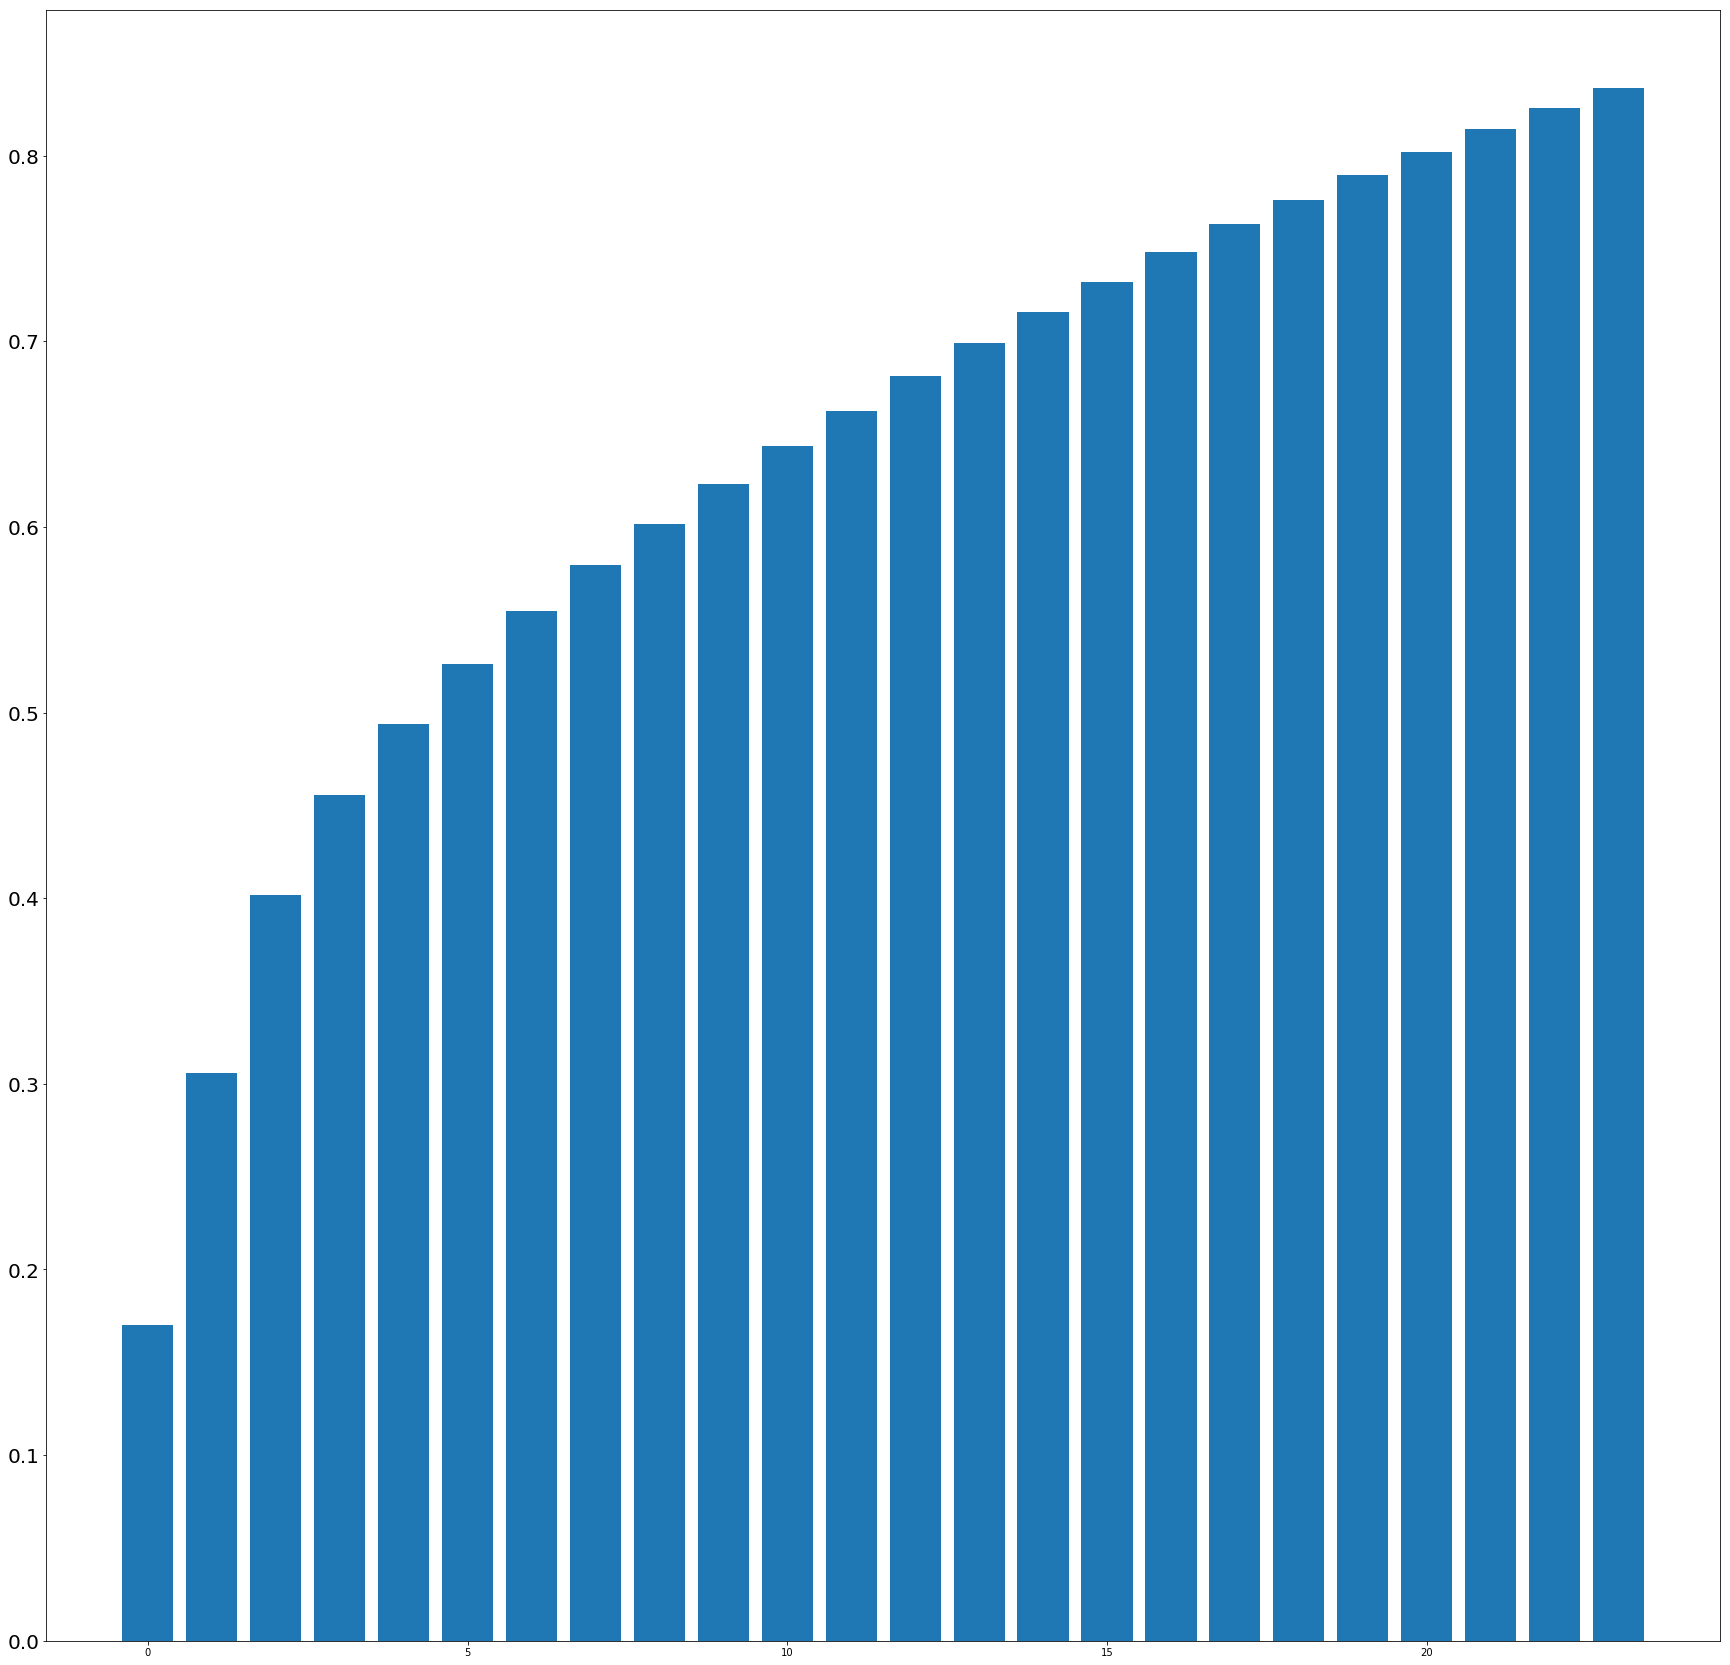

In [93]:
# Examining the bar chart of the variance dataset
plt.figure(figsize=(30,30))
plt.bar(variance['index'],variance['cumsum'])
#plt.rc('ytick', labelsize=30)
plt.rcParams.update({'font.size': 10})
#plt.yticks(0,0.2,1)

In [12]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components = 20)
pca.fit(subset1)

PCA(copy=True, iterated_power='auto', n_components=20, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

In [95]:
# Saving the dataset to a CSV file
subset1.to_csv('subset_pca.csv')

In [96]:
# Reading the csv file 
subset_pca = pd.read_csv('subset_pca.csv')

### Discussion 2.2: Perform Dimensionality Reduction

From the bar graph above, I find that 80% of the variance is explained by 20 principal components. I find that to be a suitable amount of the components to retain. We also see that beyond 20, the increase in variance is minimal.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [95]:
# Examining processed dataset values
from sklearn import preprocessing
#data_scaled = pd.DataFrame(preprocessing.scale(subset1),columns = subset1.columns)
comp_data=[]
comp_data =  pd.DataFrame(pca.components_)
comp_data.head()


0         1         2         3         4         5         6   \
0 -0.124314  0.007534 -0.222315  0.151924 -0.119406  0.074116  0.080784   
1  0.257062  0.093162  0.061111 -0.232205  0.229343 -0.203541 -0.225263   
2  0.079657 -0.367791  0.155249 -0.106648  0.101116 -0.190746 -0.100199   
3 -0.047138  0.038851  0.062273 -0.001924 -0.018422 -0.123189  0.081103   
4 -0.000990  0.008108  0.087256 -0.007879 -0.061038  0.039311 -0.050807   

         7         8         9     ...           53        54        55  \
0  0.160624 -0.110968  0.039168    ...     0.217453  0.041610 -0.166549   
1  0.119744 -0.017478 -0.058962    ...     0.094369  0.014064 -0.076243   
2 -0.042305  0.048541 -0.030608    ...     0.048571  0.004950 -0.041000   
3 -0.102708  0.398797  0.002439    ...     0.080948  0.136910  0.034411   
4 -0.088927  0.058459  0.000969    ...     0.022833 -0.484884 -0.402310   

         56        57        58        59        60        61        62  
0  0.142363  0.196073  0.134501  0.111489  0.110968  0.205094 -0.125090  
1  0.070580  0.095662  0.068217 -0.239423  0.017478  0.078252 -0.001282  
2  0.036751  0.050299  0.033870 -0.111232 -0.048541  0.029411 -0.010042  
3  0.051644  0.247129  0.095807  0.030768 -0.398797 -0.122730  0.061012  
4  0.220851  0.091659  0.149420  0.019114 -0.058459 -0.005628  0.022305  

[5 rows x 63 columns]

In [105]:
comp_data.columns = subset1.columns

In [106]:
# Examining the shape of the dataset
comp_data.shape

(20, 63)

In [107]:
# Creating a dataframe of with the first component
p1=[]
p1 = pd.DataFrame(comp_data.head(1))

In [108]:
# Looking at the columns that have the highest variance values
p1.sort_values(by=0,axis=1,ascending=False)

PLZ8_ANTG3  PLZ8_ANTG4     weath  HH_EINKOMMEN_SCORE  ORTSGR_KLS9  \
0    0.225293    0.217453  0.205094            0.202919     0.196073   

   EWDICHTE  FINANZ_HAUSBAUER  KBA05_ANTG4  PLZ8_ANTG2  FINANZ_SPARER  \
0  0.193936          0.160624     0.153608    0.153348       0.151924   

      ...      lifespan  BALLRAUM  INNENSTADT  PLZ8_GBZ  KONSUMNAEHE  \
0     ...      -0.12509 -0.126589   -0.163907 -0.166549    -0.167045   

   KBA05_GBZ  KBA05_ANTG1  FINANZ_MINIMALIST  PLZ8_ANTG1  MOBI_REGIO  
0  -0.215772    -0.216945          -0.222315   -0.225323   -0.229026  

[1 rows x 63 columns]

In [109]:
# Looking at the dictionary dataset
import markdown
dict_ = open('Data_Dictionary.md', 'r')
dict_mark =markdown.markdown(dict_.read())
dict_mark


'<h1>Data Dictionary for Identify Customer Segments Data</h1>\n<h2>Introduction</h2>\n<p>The data for this project consist of two files:</p>\n<ul>\n<li>Udacity_AZDIAS_Subset.csv: demographics data for the general population of\n      Germany; 891211 persons (rows) x 85 features (columns)</li>\n<li>Udacity_CUSTOMERS_Subset.csv: demographics data for customers of a mail-order\n      company; 191652 persons (rows) x 85 features (columns)</li>\n</ul>\n<p>The columns in the general demographics file and customers data file are the\nsame. This file documents the features that appear in the data files, sorted in\norder of appearance. Sections of this file is based on the level of measurement\nof each feature. The file "AZDIAS_Feature_Summary.csv" contains a summary of\nfeature attributes, including information level, data type, and codes for\nmissing or unknown values.</p>\n<h3>Table of Contents</h3>\n<ol>\n<li>Person-level features</li>\n<li>Household-level features</li>\n<li>Building-level 

In [110]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p2=[]
p2 = pd.DataFrame(comp_data.head(2))
p2.sort_values(by=1,axis=1,ascending=False)

ALTERSKATEGORIE_GROB  SEMIO_ERL  FINANZ_VORSORGER  SEMIO_LUST  \
0             -0.124314  -0.079673         -0.119406   -0.077037   
1              0.257062   0.230276          0.229343    0.179678   

   RETOURTYP_BK_S  FINANZ_HAUSBAUER  SEMIO_KRIT  SEMIO_KAEM  W_KEIT_KIND_HH  \
0       -0.021186          0.160624    0.003905    0.039241        0.036594   
1        0.162443          0.119744    0.118659    0.115848        0.113715   

   PLZ8_ANTG3    ...      SEMIO_RAT  SEMIO_FAM  FINANZ_ANLEGER  SEMIO_KULT  \
0    0.225293    ...       0.099075   0.080673        0.074116    0.074971   
1    0.099557    ...      -0.167401  -0.183889       -0.203541   -0.220677   

   FINANZ_UNAUFFAELLIGER  SEMIO_PFLICHT  SEMIO_TRADV  FINANZ_SPARER    decade  \
0               0.080784       0.120010     0.092922       0.151924  0.111489   
1              -0.225263      -0.227191    -0.228392      -0.232205 -0.239423   

   SEMIO_REL  
0   0.117444  
1  -0.254794  

[2 rows x 63 columns]

In [111]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
p3=[]
p3 = pd.DataFrame(comp_data.head(3))
p3.sort_values(by=2,axis=1,ascending=False)


SEMIO_VERT  SEMIO_SOZ  SEMIO_FAM  SEMIO_KULT  FINANZ_MINIMALIST  \
0   -0.039924   0.042567   0.080673    0.074971          -0.222315   
1   -0.071795  -0.103838  -0.183889   -0.220677           0.061111   
2    0.345901   0.262834   0.248958    0.232860           0.155249   

   RETOURTYP_BK_S  FINANZ_VORSORGER  W_KEIT_KIND_HH  ALTERSKATEGORIE_GROB  \
0       -0.021186         -0.119406        0.036594             -0.124314   
1        0.162443          0.229343        0.113715              0.257062   
2        0.109363          0.101116        0.084919              0.079657   

   SEMIO_REL    ...      FINANZ_UNAUFFAELLIGER  FINANZ_SPARER    decade  \
0   0.117444    ...                   0.080784       0.151924  0.111489   
1  -0.254794    ...                  -0.225263      -0.232205 -0.239423   
2   0.068286    ...                  -0.100199      -0.106648 -0.111232   

   SEMIO_ERL  FINANZ_ANLEGER  SEMIO_RAT  SEMIO_KRIT  SEMIO_DOM  SEMIO_KAEM  \
0  -0.079673        0.074116   0.099075    0.003905   0.023314    0.039241   
1   0.230276       -0.203541  -0.167401    0.118659   0.072784    0.115848   
2  -0.174252       -0.190746  -0.217367   -0.273486  -0.312984   -0.335744   

   ANREDE_KZ  
0   0.007534  
1   0.093162  
2  -0.367791  

[3 rows x 63 columns]

### Discussion 2.3: Interpret Principal Components

- On looking at the first row, we find that the column with the highest variance is PLZ8_ANTG3 (Number of 6-10 family houses in the PLZ8 area). The column with the second highest variance is PLZ8_ANTG4 (Number of 10+ family houses in the PLZ8 area). The columns with the third and fourth highest variance is weath(German cameo mapped to international code) and HH_EINKOMMEN_SCORE(Estimated household net income). The PLZ8_ANTG1 and FINANZ-MINIMALIST correspond to Number of 1-2 family houses in the PLZ8 region and low financial interest in financial typology. The FINANZ-MINIMALIST makes sense as a negative number as the individuals have positive weath value and have very high income from the HH_EINKOMMEN_SCORE. The negative FINANZ-MINIMALIST value could mean that individuals have high financial interest. The negative PLZ8_ANTG1 value could mean that there are no people with 1-2 family houses, since PLZ8_ANTG3 and PLZ8_ANTG4 have positive values. 

- On the second row, we find the first to fourth ranking by variance to be ALTERSKATEGORIE_GROB(Estimated age based on given name analysis), SEMIO_ERL(personality typology-event oriented), FINANZ_VORSORGER(Financial typology- be prepared) and SEMIO_LUST(Personality typology-sensual minded). SEMIO_TRADV(Personality typology-traditional minded), FINANZ_SPARER(Financial typology-money saver), decade(generation by decade), SEMIO_REL(Personality typology-relgious) have fourth highest to highest negative variances. The negative FINANZ_SPARER means that he is not money saver and we can see that positive FINANZ_HAUSBAUER means home ownership. The SEMIO_REL and SEMIO_TRADV are opposites of SEMIO_ERL and SEMIO_LUST which explains the negative values in the two columns.

- On the third row, we find the first to fourth ranking by variance to be SEMIO_VERT(Personality typology-dreamful),	SEMIO_SOZ(Personality typology-socially minded), SEMIO_FAM(Personality typology-family minded) and SEMIO_KULT(Personality typology-cultural minded)	.SEMIO_KRIT(Personality typology-critical minded),SEMIO_DOM(Perosnality typology-dominant minded),	SEMIO_KAEM(Personality typology-combative minded) and ANREDE_KZ(Gender) are fourth to first negative variances. SEMIO_KRIT, SEMIO_DOM and SEMIO_KAEM are opposites of the SEMIO_VERT, SEMIO_SOZ and SEMIO_FAM columns, which explains the negative variance values.



## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [ ]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
kscore=[]    
from sklearn.cluster import KMeans  
kmeans = KMeans(n_clusters=3).fit(subset1)
kscore.append(kmeans.score(subset1))

In [ ]:
# Running k-means with 4 clusters
kmeans1 = KMeans(n_clusters=4).fit(subset1)
kscore.append(kmeans1.score(subset1))

In [90]:
# Running k-means with 5 clusters
kmeans2 = KMeans(n_clusters=5).fit(subset1)
kscore.append(kmeans2.score(subset1))

In [91]:
# Running k-means with 6 clusters
kmeans3 = KMeans(n_clusters=6).fit(subset1)
kscore.append(kmeans3.score(subset1))

In [92]:
# Running k-means with 7 clusters
kmeans4 = KMeans(n_clusters=7).fit(subset1)
kscore.append(kmeans4.score(subset1))

In [93]:
# Running k-means with 8 clusters
kmeans8 = KMeans(n_clusters=8).fit(subset1)
kscore.append(kmeans8.score(subset1))

In [94]:
# Running k-means with 9 clusters
kmeans9 = KMeans(n_clusters=9).fit(subset1)
kscore.append(kmeans9.score(subset1))

NameError: name 'kmeans9score' is not defined

In [ ]:
# Running k-means with 10 clusters
kmeans10 = KMeans(n_clusters=10).fit(subset1)
kscore.append(kmeans10.score(subset1))

In [ ]:
# Examining the scores
kscore

In [104]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
from sklearn.cluster import KMeans  
def get_kmeans_score(data, center):
    
    kmeans = KMeans(n_clusters = center, n_init=10, max_iter=300, random_state=42)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score


In [ ]:
#creating a dataframe for analysis
score = []
centroids = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

for x in centroids:
    score.append(get_kmeans_score(subset1,x))

In [ ]:
#Making a dataframe
score = pd.DataFrame(score)

In [59]:
# checking the dataset for errors check how
score

0
0  3.451463e+07
1  2.975918e+07
2  2.756201e+07
3  2.678209e+07

In [ ]:
#plotting the scatter plot
plt.plot(inv, inv.index, linestyle='--', marker='o', color='b');

In [ ]:
# Transferring the dataset to a csv file
score.to_csv('kmeans_score.csv')

In [153]:
# Reading from a csv file
kmeans_score = pd.read_csv('kmeans_score.csv')

In [154]:
#Making a dataframe
kmeans_score = pd.DataFrame(kmeans_score)

In [155]:
# Examining the dataframe
kmeans_score

Unnamed: 0             0
0            0  3.451463e+07
1            1  2.975918e+07
2            2  2.756201e+07
3            3  2.678209e+07
4            4  2.623291e+07
5            5  2.546226e+07
6            6  2.517953e+07
7            7  2.442150e+07
8            8  2.400038e+07
9            9  2.361268e+07
10          10  2.320980e+07
11          11  2.271379e+07
12          12  2.245438e+07
13          13  2.237902e+07
14          14  2.155805e+07
15          15  2.132601e+07
16          16  2.070142e+07

In [156]:
# List of clusters
x = [2,4,6,7,8,9,10,11,12,13,14,15,16,18,20,22,25]

In [157]:
#Creating a new column
kmeans_score['index'] = x

In [158]:
# Viewing the dataframe
kmeans_score

Unnamed: 0             0  index
0            0  3.451463e+07      2
1            1  2.975918e+07      4
2            2  2.756201e+07      6
3            3  2.678209e+07      7
4            4  2.623291e+07      8
5            5  2.546226e+07      9
6            6  2.517953e+07     10
7            7  2.442150e+07     11
8            8  2.400038e+07     12
9            9  2.361268e+07     13
10          10  2.320980e+07     14
11          11  2.271379e+07     15
12          12  2.245438e+07     16
13          13  2.237902e+07     18
14          14  2.155805e+07     20
15          15  2.132601e+07     22
16          16  2.070142e+07     25

In [159]:
# Rename the columns
kmeans_score.columns = ['unknown','values','index']

In [160]:
# Examine the values
kmeans_score['values']

0     3.451463e+07
1     2.975918e+07
2     2.756201e+07
3     2.678209e+07
4     2.623291e+07
5     2.546226e+07
6     2.517953e+07
7     2.442150e+07
8     2.400038e+07
9     2.361268e+07
10    2.320980e+07
11    2.271379e+07
12    2.245438e+07
13    2.237902e+07
14    2.155805e+07
15    2.132601e+07
16    2.070142e+07
Name: values, dtype: float64

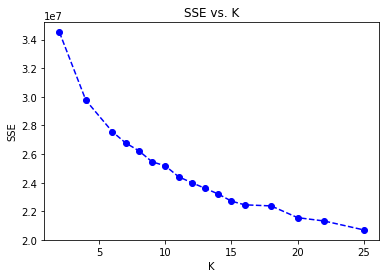

In [161]:
# View the change in within-cluster distance
plt.plot(kmeans_score['index'], kmeans_score['values'], linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');
plt.figure(figsize=(50,80))

In [13]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
from sklearn.cluster import KMeans
new_score=[]
kmeans1 = KMeans(n_clusters=20).fit(subset1)
new_score.append(kmeans1.score(subset1))

In [14]:
# Predicting the general population demographics based on kmeans
general_predict = kmeans1.predict(subset1)

### Discussion 3.1: Apply Clustering to General Population

On plotting the kmeans scores with the number of clusters, we find that the slope of the curve starts to decrease when the number of clusters is 20. I believe that 20 is a good number to map the points in the dataset.



### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [15]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers= pd.DataFrame(customers)

In [16]:
# Examine the customer dataset
customers.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [17]:
# Examine thc columns and datatypes in the customers dataset
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [127]:
# Checking the OST_WEST_KZ column
customers['OST_WEST_KZ'].value_counts()

W    130382
O     11343
Name: OST_WEST_KZ, dtype: int64

In [128]:
# checking the VERS_TYP column
customers['VERS_TYP'].value_counts()

 1    73620
 2    69042
-1    48990
Name: VERS_TYP, dtype: int64

In [129]:
customers.reset_index(drop=True)

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0              2                     4          1            5.0   
1             -1                     4          1            NaN   
2             -1                     4          2            2.0   
3              1                     4          1            2.0   
4             -1                     3          1            6.0   
5              1                     3          1            4.0   
6              2                     4          1            2.0   
7              1                     4          1            2.0   
8              2                     4          2            1.0   
9              1                     3          1            3.0   
10            -1                     3          2            5.0   
11             1                     4          1            3.0   
12            -1                     4          1            5.0   
13            -1                     3          1            6.0   
14             2                     4          2            2.0   
15             2                     3          1            3.0   
16             1                     4          1            2.0   
17            -1                     4          1            5.0   
18            -1                     2          1            4.0   
19            -1                     4          2            4.0   
20            -1                     4          1            6.0   
21             2                     4          1            1.0   
22             2                     1          2            2.0   
23            -1                     3          1            6.0   
24             2                     4          2            2.0   
25            -1                     3          2            3.0   
26             1                     4          2            2.0   
27            -1                     3          1            3.0   
28             2                     4          2            2.0   
29             0                     3          2            4.0   
...          ...                   ...        ...            ...   
191622         2                     4          1            2.0   
191623         1                     4          1            2.0   
191624         1                     4          1            2.0   
191625         2                     4          2            4.0   
191626        -1                     2          1            4.0   
191627         3                     3          2            2.0   
191628         1                     4          1            2.0   
191629         2                     4          2            1.0   
191630         2                     3          1            2.0   
191631         2                     4          2            1.0   
191632         0                     3          1            5.0   
191633         1                     4          1            3.0   
191634         2                     3          1            1.0   
191635         2                     4          2            2.0   
191636         2                     4          1            1.0   
191637        -1                     3          2            6.0   
191638         1                     4          1            6.0   
191639        -1                     3          1            5.0   
191640         3                     3          1            4.0   
191641         1                     4          1            2.0   
191642         2                     4          2            2.0   
191643         2                     4          1            5.0   
191644         2                     4          2            6.0   
191645         2                     4          1            5.0   
191646         3                     2          2            2.0   
191647         1                     3          1            4.0   
191648        -1                     4          2            2.0

In [130]:
customers.head()

AGER_TYP  ALTERSKATEGORIE_GROB  ANREDE_KZ  CJT_GESAMTTYP  \
0         2                     4          1            5.0   
1        -1                     4          1            NaN   
2        -1                     4          2            2.0   
3         1                     4          1            2.0   
4        -1                     3          1            6.0   

   FINANZ_MINIMALIST  FINANZ_SPARER  FINANZ_VORSORGER  FINANZ_ANLEGER  \
0                  5              1                 5               1   
1                  5              1                 5               1   
2                  5              1                 5               1   
3                  5              1                 5               2   
4                  3              1                 4               4   

   FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER    ...     PLZ8_ANTG1  PLZ8_ANTG2  \
0                      2                 2    ...            3.0         3.0   
1                      3                 2    ...            NaN         NaN   
2                      4                 4    ...            2.0         3.0   
3                      1                 2    ...            3.0         2.0   
4                      5                 2    ...            2.0         4.0   

   PLZ8_ANTG3  PLZ8_ANTG4  PLZ8_BAUMAX  PLZ8_HHZ  PLZ8_GBZ  ARBEIT  \
0         1.0         0.0          1.0       5.0       5.0     1.0   
1         NaN         NaN          NaN       NaN       NaN     NaN   
2         3.0         1.0          3.0       3.0       2.0     3.0   
3         1.0         0.0          1.0       3.0       4.0     1.0   
4         2.0         1.0          2.0       3.0       3.0     3.0   

   ORTSGR_KLS9  RELAT_AB  
0          2.0       1.0  
1          NaN       NaN  
2          5.0       3.0  
3          3.0       1.0  
4          5.0       1.0  

[5 rows x 85 columns]

In [131]:
# Cleaning the customers dataset using the clean_data function
customers_new  = clean_data(customers)

In [132]:
# Save the cleaned dataset to csv
customers_new.to_csv('customers_cleaned.csv', sep=';', index = False)

In [18]:
# Read the cleaned dataset 
customers_cleaned = pd.read_csv('customers_cleaned.csv', sep=';') 

In [19]:
# Checking for null values
customers_cleaned[customers_cleaned.isnull().any(1)]

Empty DataFrame
Columns: [ALTERSKATEGORIE_GROB, ANREDE_KZ, FINANZ_MINIMALIST, FINANZ_SPARER, FINANZ_VORSORGER, FINANZ_ANLEGER, FINANZ_UNAUFFAELLIGER, FINANZ_HAUSBAUER, GREEN_AVANTGARDE, HEALTH_TYP, RETOURTYP_BK_S, SEMIO_SOZ, SEMIO_FAM, SEMIO_REL, SEMIO_MAT, SEMIO_VERT, SEMIO_LUST, SEMIO_ERL, SEMIO_KULT, SEMIO_RAT, SEMIO_KRIT, SEMIO_DOM, SEMIO_KAEM, SEMIO_PFLICHT, SEMIO_TRADV, SOHO_KZ, ANZ_PERSONEN, ANZ_TITEL, HH_EINKOMMEN_SCORE, W_KEIT_KIND_HH, WOHNDAUER_2008, ANZ_HAUSHALTE_AKTIV, ANZ_HH_TITEL, KONSUMNAEHE, MIN_GEBAEUDEJAHR, OST_WEST_KZ, KBA05_ANTG1, KBA05_ANTG2, KBA05_ANTG3, KBA05_ANTG4, KBA05_GBZ, BALLRAUM, EWDICHTE, INNENSTADT, GEBAEUDETYP_RASTER, KKK, MOBI_REGIO, ONLINE_AFFINITAET, REGIOTYP, KBA13_ANZAHL_PKW, PLZ8_ANTG1, PLZ8_ANTG2, PLZ8_ANTG3, PLZ8_ANTG4, PLZ8_HHZ, PLZ8_GBZ, ARBEIT, ORTSGR_KLS9, RELAT_AB, decade, PRAEGENDE_JUGENDJAHRE_binary, weath, lifespan]
Index: []

[0 rows x 63 columns]

In [20]:
# Creating a dataframe
customers_cleaned = pd.DataFrame(customers_cleaned)

In [21]:
# Examining the cleaned dataframe
customers_cleaned.head()

ALTERSKATEGORIE_GROB  ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0                   4.0          1                  5              1   
1                   4.0          2                  5              1   
2                   4.0          1                  5              1   
3                   3.0          1                  3              1   
4                   3.0          1                  5              1   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0                 5               1                      2                 2   
1                 5               1                      4                 4   
2                 5               2                      1                 2   
3                 4               4                      5                 2   
4                 5               1                      2                 3   

   GREEN_AVANTGARDE  HEALTH_TYP    ...     PLZ8_ANTG4  PLZ8_HHZ  PLZ8_GBZ  \
0                 1         1.0    ...            0.0       5.0       5.0   
1                 1         2.0    ...            1.0       3.0       2.0   
2                 0         2.0    ...            0.0       3.0       4.0   
3                 0         3.0    ...            1.0       3.0       3.0   
4                 1         3.0    ...            1.0       5.0       5.0   

   ARBEIT  ORTSGR_KLS9  RELAT_AB  decade  PRAEGENDE_JUGENDJAHRE_binary  weath  \
0     1.0          2.0       1.0     2.0                           0.0      1   
1     3.0          5.0       3.0     2.0                           0.0      3   
2     1.0          3.0       1.0     1.0                           1.0      2   
3     3.0          5.0       1.0     4.0                           1.0      4   
4     3.0          7.0       5.0     2.0                           0.0      3   

   lifespan  
0         3  
1         4  
2         4  
3         1  
4         4  

[5 rows x 63 columns]

In [22]:
# Converting all the columns to numeric datatype
for n in customers_cleaned.columns:
    customers_cleaned[n] = pd.to_numeric(customers_cleaned[n], errors='coerce')

In [23]:
# Examining the datatypes and columns in the cleaned dataset
customers_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139229 entries, 0 to 139228
Data columns (total 63 columns):
ALTERSKATEGORIE_GROB            139229 non-null float64
ANREDE_KZ                       139229 non-null int64
FINANZ_MINIMALIST               139229 non-null int64
FINANZ_SPARER                   139229 non-null int64
FINANZ_VORSORGER                139229 non-null int64
FINANZ_ANLEGER                  139229 non-null int64
FINANZ_UNAUFFAELLIGER           139229 non-null int64
FINANZ_HAUSBAUER                139229 non-null int64
GREEN_AVANTGARDE                139229 non-null int64
HEALTH_TYP                      139229 non-null float64
RETOURTYP_BK_S                  139229 non-null float64
SEMIO_SOZ                       139229 non-null int64
SEMIO_FAM                       139229 non-null int64
SEMIO_REL                       139229 non-null int64
SEMIO_MAT                       139229 non-null int64
SEMIO_VERT                      139229 non-null int64
SEMIO_LUST         

In [24]:
# Making sure that all the columns in the customers cleaned datset is in the subset1 dataset
needed=[]
for col in customers_cleaned:
    if col in subset1.columns:
        print('yes')
    else:
        needed.append(col)

yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes
yes


In [25]:
# Examining the dataset to find out which columns dont match
needed

[]

In [26]:
# Dropping the excess columns
customers_cleaned.drop(needed,  axis=1, inplace=True)

In [27]:
# normalizing and transfoming the dataset using the standard scaler 
customers_cleaned[customers_cleaned.columns] = normalizer.transform(customers_cleaned[customers_cleaned.columns].as_matrix())

In [28]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
pca.transform(customers_cleaned)
customer_predict = kmeans1.predict(customers_cleaned)




### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [220]:
general_predict

array([ 4, 15, 19, ...,  8, 11,  7], dtype=int32)

In [221]:
len(general_predict)

781280

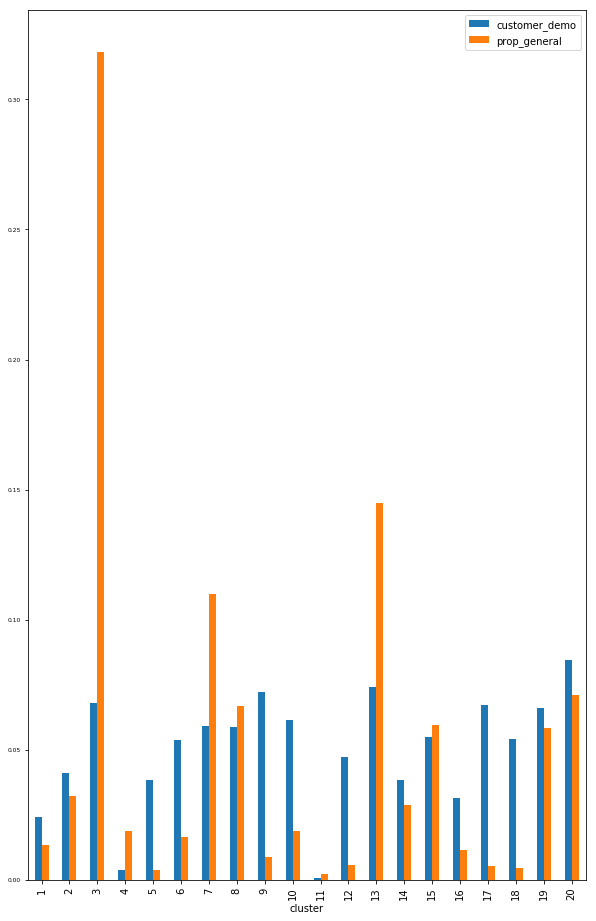

In [211]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
prop_cust=[]
prop_general=[]
for i in range(0,20):
    prop_cust.append((general_predict==i).sum()/len(general_predict))
    prop_general.append((customer_predict==i).sum()/len(customer_predict))

x = [i+1 for i in range(0,20)]
    
final = pd.DataFrame({'cluster': x, 'customer_demo': prop_cust, 'prop_general': prop_general})
final.plot(x='cluster', y=['customer_demo', 'prop_general'], kind='bar', figsize=(10,16))
plt.show()
    



In [30]:
# Examining a cluster to look at the values in the cluster
data_3 = normalizer.inverse_transform(pca.inverse_transform(hash(tuple(customers_cleaned)))).round()

customer_under_rep_features = pd.DataFrame(data_3).round(2)
customer_under_rep_features


0             1             2             3             4   \
0   6.753507e+17 -2.009562e+16  1.636000e+18 -1.206177e+18  8.777528e+17   
1  -1.396518e+18 -2.485040e+17 -4.497143e+17  1.843553e+18 -1.685904e+18   
2  -4.327464e+17  9.810654e+17 -1.142466e+18  8.467143e+17 -7.433082e+17   
3   2.560706e+17 -1.036359e+17 -4.582575e+17  1.525498e+16  1.353837e+17   
4   5.479757e+15 -2.170239e+16 -6.424000e+17  6.251396e+16  4.486816e+17   
5  -2.747016e+16 -2.507263e+16  1.083050e+17 -6.210695e+16  2.536840e+17   
6  -2.959965e+17  1.039153e+17 -5.315129e+17 -2.304754e+17  5.381655e+16   
7  -6.861402e+17  4.286909e+16  6.148139e+17 -7.268677e+17  9.593512e+17   
8  -6.832154e+17  1.853316e+17  1.015703e+18 -1.737808e+18  9.952998e+17   
9   1.493866e+17 -5.301452e+15 -5.383546e+17  7.305193e+17 -1.333089e+18   
10  9.801574e+16 -9.598068e+16  6.922015e+17 -1.146836e+17 -3.011995e+17   
11  6.142930e+16  1.756474e+17 -1.138630e+18  2.076918e+17  3.655302e+17   
12 -1.985878e+17 -1.335259e+17  3.253671e+17  4.713515e+16 -1.652405e+17   
13  2.893195e+17  1.556267e+17  7.052806e+17 -2.465183e+17 -3.224955e+17   
14 -7.331428e+16  4.463707e+16 -5.561978e+16  2.074711e+17  3.343265e+17   
15 -3.461406e+17  6.497397e+16 -2.847121e+17  3.473539e+17 -3.368667e+17   
16  7.966114e+15  1.149483e+15 -5.813167e+15 -2.509600e+16  3.594087e+16   
17  7.768568e+17 -9.704454e+16 -3.928777e+17  1.293376e+18 -1.608724e+18   
18 -2.574415e+16 -8.065549e+15  2.277047e+17  1.200198e+17 -2.886392e+17   
19 -1.124019e+17  7.035195e+15 -7.182784e+16 -2.524331e+17  1.475062e+17   

              5             6             7             8             9   \
0  -5.830731e+17 -6.012278e+17 -1.199957e+18  2.454569e+17 -1.581590e+17   
1   1.601260e+18  1.676494e+18 -8.945563e+17  3.866050e+16  2.380867e+17   
2   1.500607e+18  7.457197e+17  3.160411e+17 -1.073716e+17  1.235942e+17   
3   9.690791e+17 -6.035813e+17  7.672783e+17 -8.821298e+17 -9.851084e+15   
4  -3.093373e+17  3.783921e+17  6.648685e+17 -1.293305e+17 -3.739176e+15   
5  -1.669885e+17  8.917659e+16  3.939803e+16 -3.600105e+16  8.377736e+16   
6  -4.663363e+17 -2.614963e+17  1.503461e+18  4.472872e+16 -3.428321e+17   
7  -9.187340e+17 -2.967977e+17 -4.013104e+17 -9.106840e+16  5.146572e+17   
8  -9.490902e+17 -2.140122e+18  2.911659e+17 -1.321208e+17 -5.900871e+17   
9   1.177739e+18  3.346655e+17  8.492253e+17  2.514750e+17 -2.972388e+17   
10 -6.223948e+17  4.949393e+17 -1.711658e+18 -2.764677e+16  5.774456e+17   
11  5.637926e+16  5.068252e+17  1.853284e+18  1.247903e+17 -1.875243e+18   
12  1.708216e+17 -1.004624e+18 -2.993992e+16 -2.821926e+17  1.728282e+18   
13  2.605651e+17  4.793571e+15 -4.648105e+17  9.567957e+16 -1.334559e+18   
14  4.419042e+16  6.385064e+17 -5.488356e+17  6.866353e+17  1.493821e+17   
15  1.251720e+18 -2.252398e+17  7.975152e+17  4.845364e+17  8.082097e+17   
16 -6.271229e+16 -1.343982e+16  1.264403e+16 -5.308017e+15 -7.547944e+16   
17  6.511191e+17  1.437649e+18 -8.569137e+17 -2.814518e+17 -1.667510e+17   
18  1.985323e+17  8.068302e+17 -8.210593e+17 -1.533719e+17  7.907027e+16   
19  2.533554e+17 -9.443704e+17  5.057464e+17  5.363761e+17  5.160636e+17   

        ...                 53            54            55            56  \
0       ...      -8.441037e+17 -2.156267e+17  9.838017e+17 -7.571911e+17   
1       ...      -3.663196e+17 -7.288030e+16  4.503676e+17 -3.753985e+17   
2       ...      -1.885391e+17 -2.565157e+16  2.421823e+17 -1.954687e+17   
3       ...      -3.142354e+17 -7.094795e+17 -2.032592e+17 -2.746803e+17   
4       ...      -8.853268e+16  2.512728e+18  2.376376e+18 -1.174764e+18   
5       ...      -3.466590e+17  4.705364e+16  3.896565e+17  9.150497e+17   
6       ...      -2.387745e+17 -1.349479e+18 -9.012965e+17 -2.521193e+17   
7       ...      -2.932724e+17 -1.762191e+17  2.119096e+17 -3.289215e+16   
8       ...       1.901887e+17  8.090941e+17  4.932782e+17  1.142815e+18   
9       ...       4.634567e+16  1.096404e+18  9.113317e+17  

In [31]:
customer_under_rep_features.columns = customers_cleaned.columns

In [32]:
customer_under_rep_features.head()

ALTERSKATEGORIE_GROB     ANREDE_KZ  FINANZ_MINIMALIST  FINANZ_SPARER  \
0          6.753507e+17 -2.009562e+16       1.636000e+18  -1.206177e+18   
1         -1.396518e+18 -2.485040e+17      -4.497143e+17   1.843553e+18   
2         -4.327464e+17  9.810654e+17      -1.142466e+18   8.467143e+17   
3          2.560706e+17 -1.036359e+17      -4.582575e+17   1.525498e+16   
4          5.479757e+15 -2.170239e+16      -6.424000e+17   6.251396e+16   

   FINANZ_VORSORGER  FINANZ_ANLEGER  FINANZ_UNAUFFAELLIGER  FINANZ_HAUSBAUER  \
0      8.777528e+17   -5.830731e+17          -6.012278e+17     -1.199957e+18   
1     -1.685904e+18    1.601260e+18           1.676494e+18     -8.945563e+17   
2     -7.433082e+17    1.500607e+18           7.457197e+17      3.160411e+17   
3      1.353837e+17    9.690791e+17          -6.035813e+17      7.672783e+17   
4      4.486816e+17   -3.093373e+17           3.783921e+17      6.648685e+17   

   GREEN_AVANTGARDE    HEALTH_TYP      ...         PLZ8_ANTG4      PLZ8_HHZ  \
0      2.454569e+17 -1.581590e+17      ...      -8.441037e+17 -2.156267e+17   
1      3.866050e+16  2.380867e+17      ...      -3.663196e+17 -7.288030e+16   
2     -1.073716e+17  1.235942e+17      ...      -1.885391e+17 -2.565157e+16   
3     -8.821298e+17 -9.851084e+15      ...      -3.142354e+17 -7.094795e+17   
4     -1.293305e+17 -3.739176e+15      ...      -8.853268e+16  2.512728e+18   

       PLZ8_GBZ        ARBEIT   ORTSGR_KLS9      RELAT_AB        decade  \
0  9.838017e+17 -7.571911e+17 -2.404346e+18 -9.737538e+17 -8.722789e+17   
1  4.503676e+17 -3.753985e+17 -1.173061e+18 -4.938731e+17  1.873216e+18   
2  2.421823e+17 -1.954687e+17 -6.167920e+17 -2.452050e+17  8.702682e+17   
3 -2.032592e+17 -2.746803e+17 -3.030388e+18 -6.936597e+17 -2.407153e+17   
4  2.376376e+18 -1.174764e+18 -1.123666e+18 -1.081918e+18 -1.495699e+17   

   PRAEGENDE_JUGENDJAHRE_binary         weath      lifespan  
0                 -2.454569e+17 -1.606506e+18  9.952938e+17  
1                 -3.866050e+16 -6.129515e+17  1.020268e+16  
2                  1.073716e+17 -2.303802e+17  7.990047e+16  
3                  8.821298e+17  9.613288e+17 -4.854590e+17  
4                  1.293305e+17  4.347944e+16 -1.776057e+17  

[5 rows x 63 columns]

In [38]:
customer_under_rep_features.iloc[17,:]

ALTERSKATEGORIE_GROB            7.768568e+17
ANREDE_KZ                      -9.704454e+16
FINANZ_MINIMALIST              -3.928777e+17
FINANZ_SPARER                   1.293376e+18
FINANZ_VORSORGER               -1.608724e+18
FINANZ_ANLEGER                  6.511191e+17
FINANZ_UNAUFFAELLIGER           1.437649e+18
FINANZ_HAUSBAUER               -8.569137e+17
GREEN_AVANTGARDE               -2.814518e+17
HEALTH_TYP                     -1.667510e+17
RETOURTYP_BK_S                  1.376391e+18
SEMIO_SOZ                      -9.559905e+17
SEMIO_FAM                       5.546614e+17
SEMIO_REL                       3.706716e+16
SEMIO_MAT                       1.923356e+18
SEMIO_VERT                      4.571478e+17
SEMIO_LUST                      3.095399e+18
SEMIO_ERL                       9.557955e+17
SEMIO_KULT                     -3.574567e+17
SEMIO_RAT                      -3.186169e+17
SEMIO_KRIT                      2.575234e+17
SEMIO_DOM                      -3.864086e+17
SEMIO_KAEM

In [39]:
# Examining a cluster to look at the values in the cluster
customer_under_rep_features.iloc[18,:]

ALTERSKATEGORIE_GROB           -2.574415e+16
ANREDE_KZ                      -8.065549e+15
FINANZ_MINIMALIST               2.277047e+17
FINANZ_SPARER                   1.200198e+17
FINANZ_VORSORGER               -2.886392e+17
FINANZ_ANLEGER                  1.985323e+17
FINANZ_UNAUFFAELLIGER           8.068302e+17
FINANZ_HAUSBAUER               -8.210593e+17
GREEN_AVANTGARDE               -1.533719e+17
HEALTH_TYP                      7.907027e+16
RETOURTYP_BK_S                 -1.868509e+17
SEMIO_SOZ                       9.484004e+16
SEMIO_FAM                       2.155895e+15
SEMIO_REL                       1.249990e+17
SEMIO_MAT                      -3.119531e+16
SEMIO_VERT                      2.024522e+17
SEMIO_LUST                      5.497743e+17
SEMIO_ERL                       9.054644e+16
SEMIO_KULT                      1.402933e+17
SEMIO_RAT                      -6.735541e+16
SEMIO_KRIT                      4.162169e+17
SEMIO_DOM                      -3.357186e+16
SEMIO_KAEM

In [40]:
customer_under_rep_features.iloc[9,:]

ALTERSKATEGORIE_GROB            1.493866e+17
ANREDE_KZ                      -5.301452e+15
FINANZ_MINIMALIST              -5.383546e+17
FINANZ_SPARER                   7.305193e+17
FINANZ_VORSORGER               -1.333089e+18
FINANZ_ANLEGER                  1.177739e+18
FINANZ_UNAUFFAELLIGER           3.346655e+17
FINANZ_HAUSBAUER                8.492253e+17
GREEN_AVANTGARDE                2.514750e+17
HEALTH_TYP                     -2.972388e+17
RETOURTYP_BK_S                 -1.216062e+18
SEMIO_SOZ                       3.548075e+17
SEMIO_FAM                      -2.881684e+17
SEMIO_REL                      -3.950681e+17
SEMIO_MAT                      -1.184686e+18
SEMIO_VERT                      2.761109e+17
SEMIO_LUST                      4.481292e+17
SEMIO_ERL                       1.043099e+17
SEMIO_KULT                     -3.125189e+17
SEMIO_RAT                      -8.903664e+17
SEMIO_KRIT                     -3.940863e+16
SEMIO_DOM                      -6.816128e+17
SEMIO_KAEM

In [41]:
customer_under_rep_features.iloc[3,:]

ALTERSKATEGORIE_GROB            2.560706e+17
ANREDE_KZ                      -1.036359e+17
FINANZ_MINIMALIST              -4.582575e+17
FINANZ_SPARER                   1.525498e+16
FINANZ_VORSORGER                1.353837e+17
FINANZ_ANLEGER                  9.690791e+17
FINANZ_UNAUFFAELLIGER          -6.035813e+17
FINANZ_HAUSBAUER                7.672783e+17
GREEN_AVANTGARDE               -8.821298e+17
HEALTH_TYP                     -9.851084e+15
RETOURTYP_BK_S                 -9.815475e+15
SEMIO_SOZ                      -4.355362e+16
SEMIO_FAM                       2.127389e+17
SEMIO_REL                       2.295382e+16
SEMIO_MAT                      -2.011545e+17
SEMIO_VERT                      1.910067e+17
SEMIO_LUST                      1.281999e+15
SEMIO_ERL                       2.546129e+17
SEMIO_KULT                      3.432772e+17
SEMIO_RAT                      -4.964854e+17
SEMIO_KRIT                     -1.224610e+17
SEMIO_DOM                      -1.126919e+18
SEMIO_KAEM

In [42]:
customer_under_rep_features.iloc[13,:]

ALTERSKATEGORIE_GROB            2.893195e+17
ANREDE_KZ                       1.556267e+17
FINANZ_MINIMALIST               7.052806e+17
FINANZ_SPARER                  -2.465183e+17
FINANZ_VORSORGER               -3.224955e+17
FINANZ_ANLEGER                  2.605651e+17
FINANZ_UNAUFFAELLIGER           4.793571e+15
FINANZ_HAUSBAUER               -4.648105e+17
GREEN_AVANTGARDE                9.567957e+16
HEALTH_TYP                     -1.334559e+18
RETOURTYP_BK_S                 -7.227850e+17
SEMIO_SOZ                      -9.452962e+17
SEMIO_FAM                       8.577184e+16
SEMIO_REL                       3.100224e+17
SEMIO_MAT                       2.013299e+18
SEMIO_VERT                     -5.058848e+16
SEMIO_LUST                      2.373667e+18
SEMIO_ERL                       6.479600e+17
SEMIO_KULT                     -9.599531e+15
SEMIO_RAT                       7.946133e+17
SEMIO_KRIT                     -5.041981e+16
SEMIO_DOM                      -5.960862e+17
SEMIO_KAEM

### Discussion 3.3: Compare Customer Data to Demographics Data


- The clusters 17, 18 and 9 have greater customer data than the general population. We find that the cluster 9 consists of individuals with characteristics such as estimated age less than 30 years, very high investor, high socially minded, highly dreamful, highly sensually minded and its very likely that there are children in the household to name a few.

- The clusters 13 and 3 show the greatest difference between general population and customer data. These clusters have higher general population than the customer data. The characterstics of the cluster 3 are estimated age of the household is 30-45 years, has high affinity to saving money, is highly prepared financially, very high affinity to family and very high religious affinity to name a few.

- We find that 13 out of the 20 clusters have higher customer data when compared to the general population. The general population data from any of these clusters will be suitable as a customer base. The mixed and categorical features that were removed also contain important information that will help with our analysis.


> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.